![](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

# House Prices Prediction

In [291]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import plot_model


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor
# from tensorflow.keras.layers.Layer import Sequential, Dense, ReLU
# Попросите покупателя дома описать дом своей мечты, 
# и он, вероятно, не начнет с высоты потолка подвала 
# или близости к железной дороге с востока на запад. 
# Но набор данных этого конкурса игровых площадок доказывает, 
# что гораздо больше влияет на ценовые переговоры, 
# чем количество спален или забор из белого штакетника.

# С 79 независимыми переменными, описывающими (почти) каждый аспект жилых домов в Эймсе, 
# штат Айова, этот конкурс ставит перед вами задачу предсказать окончательную цену каждого дома.

# Читаем и изучаем полученные данные

**Читаем данные и обрезаем Id столбец, он не нужен для обучения** 

In [170]:
data_train = pd.read_csv(r'train.csv')
data_train = data_train.drop('Id', axis=1)

**Выводим первые пять строк**

In [171]:
data_train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

**Необходимо произвести поиск и заполнение отсутствующих значений**

Я использовал функцию участника соревнования Kaggle https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

In [172]:
def ProcentOfMissingValue(data_train):
    missing = (round(data_train.isnull().mean()*100,10)) 
    missing = missing[missing>0].sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    missing.plot.bar()
    # plt.axis("Percent of missing values")
    plt.ylabel("Percent of missing values")
    plt.xlabel("Features")
    plt.show()
    print('Процент пропущенных значений в столбцах')
    print(missing)
    print('------------------------------------------------')
    for i in missing.index:
        print(i, data_train[i].dtype)
    
# ProcentOfMissingValue(data_train)

**Проверяем типы данных в которых отсутствую значения**

In [173]:
# for i in missing.index:
#     print(i, data_train[i].dtype)

Теоретически, можно вычислить значения которые пропущены и восстановить их. Изучим на основе цены и значений какими могут быть пропущенные значения.

1.PoolQC - качество бассейна

In [174]:
data_train['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

Мы видим, что имеется 3 класса Хорошо, прекрасно и средне. Но также имеется еще одна графа PoolArea, отображающая площадь бассейна, соответственно если данное значение равно нулю, то можно вместо значения в графе PollQC NaN заменить на None.

In [175]:
data_train['PoolArea'].value_counts()

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64

In [176]:
data_train['PoolQC'] = data_train['PoolQC'].fillna(value = 'None')

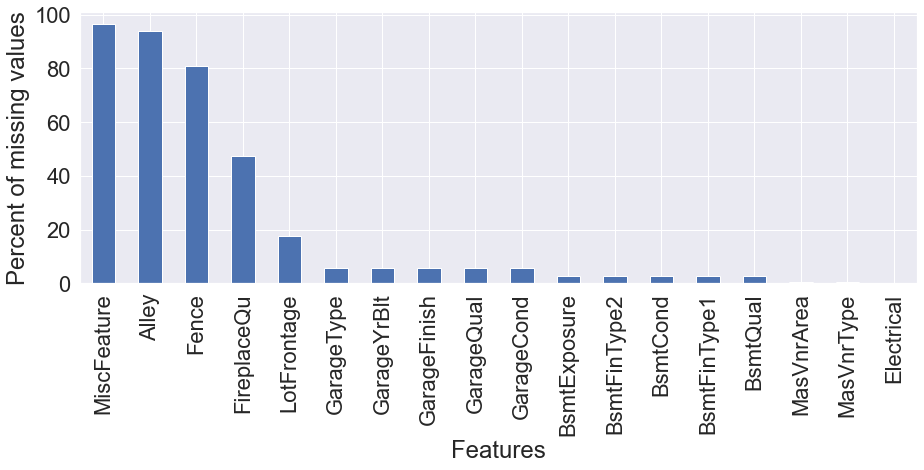

Процент пропущенных значений в столбцах
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
MiscFeature object
Alley object
Fence object
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtCond object
BsmtFinType1 object
BsmtQual object
MasVnrArea float64
MasVnrType object
Electrical object


In [177]:
ProcentOfMissingValue(data_train)

Как видно, одно значение было заменено

2. MiscFeature

In [178]:
data_train['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

Shed - сарай

Gar2 - Второй гараж


Построим диаграмму рассеивания класса и цены.

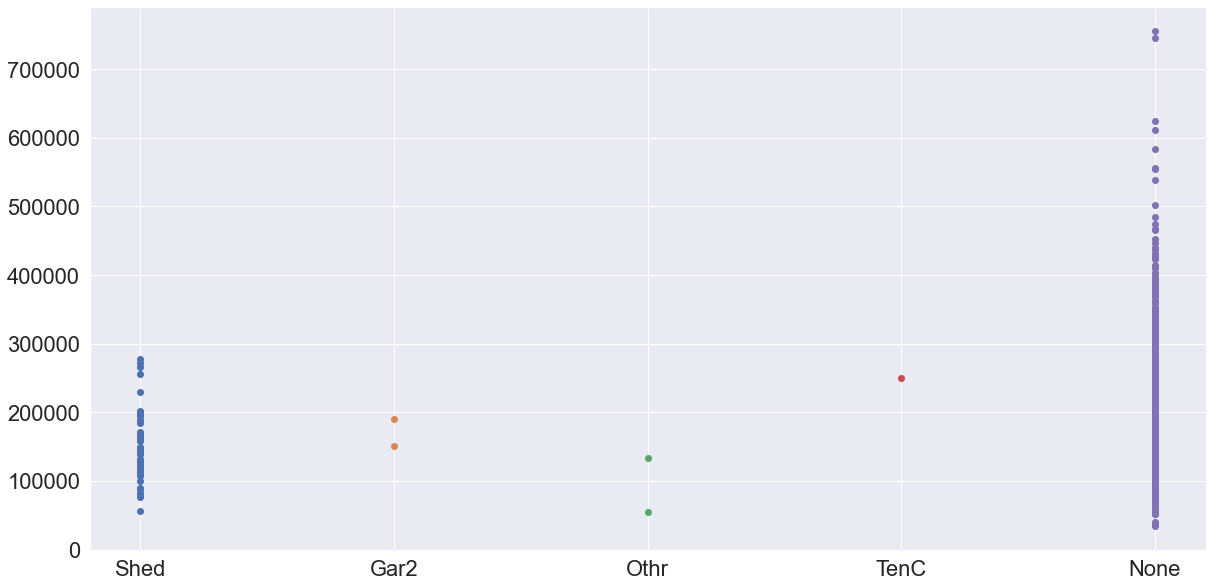

In [179]:
plt.figure(figsize=(20,10))
plt.scatter(data_train[data_train['MiscFeature'] == 'Shed']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Shed']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'Gar2']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Gar2']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'Othr']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Othr']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'TenC']['MiscFeature'],data_train[data_train['MiscFeature'] == 'TenC']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'].isna() == True]['MiscFeature'].fillna(value = 'None'), data_train[data_train['MiscFeature'].isna() == True]['SalePrice'])
plt.show()

Мы можем предположить, что у других домов отсутствуют дополнительные значения.

In [180]:
data_train['MiscFeature'] = data_train['MiscFeature'].fillna(value = 'None')

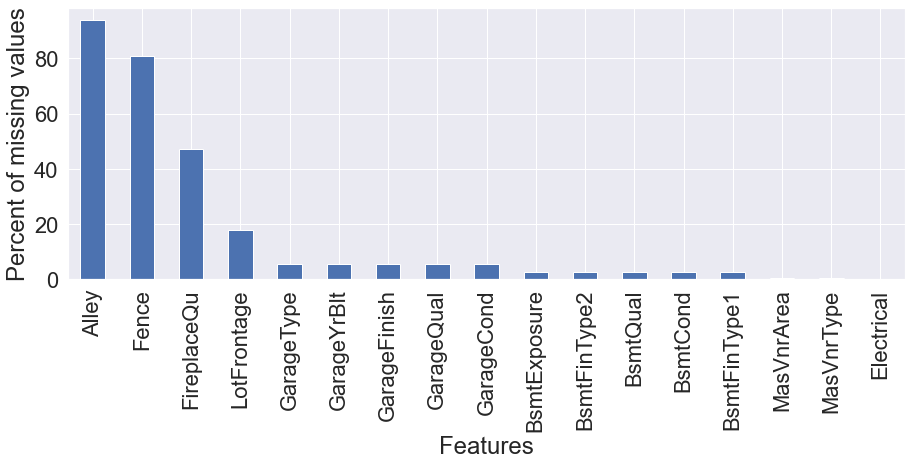

Процент пропущенных значений в столбцах
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
Alley object
Fence object
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrArea float64
MasVnrType object
Electrical object


In [181]:
ProcentOfMissingValue(data_train)

3. Alley Тип доступа к аллее

In [182]:
data_train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

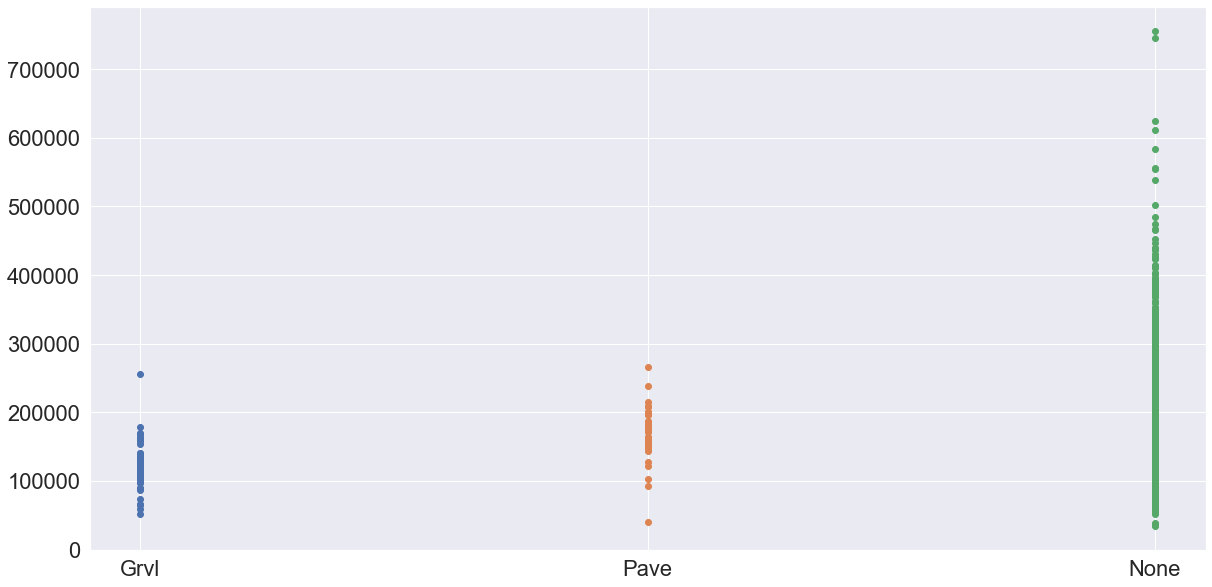

In [183]:
plt.figure(figsize=(20,10))
plt.scatter(data_train[data_train['Alley'] == 'Grvl']['Alley'],data_train[data_train['Alley'] == 'Grvl']['SalePrice'])
plt.scatter(data_train[data_train['Alley'] == 'Pave']['Alley'],data_train[data_train['Alley'] == 'Pave']['SalePrice'])
plt.scatter(data_train[data_train['Alley'].isna() == True]['Alley'].fillna(value = 'None'), data_train[data_train['Alley'].isna() == True]['SalePrice'])
plt.show()

Как можно увидеть, отсутствующий тип жилья располагается как в зоне Pave так и в зоне Grvl, таким образом мы также можем заменить данные пропущенные значения на None

In [184]:
data_train['Alley'] = data_train['Alley'].fillna(value = 'None')

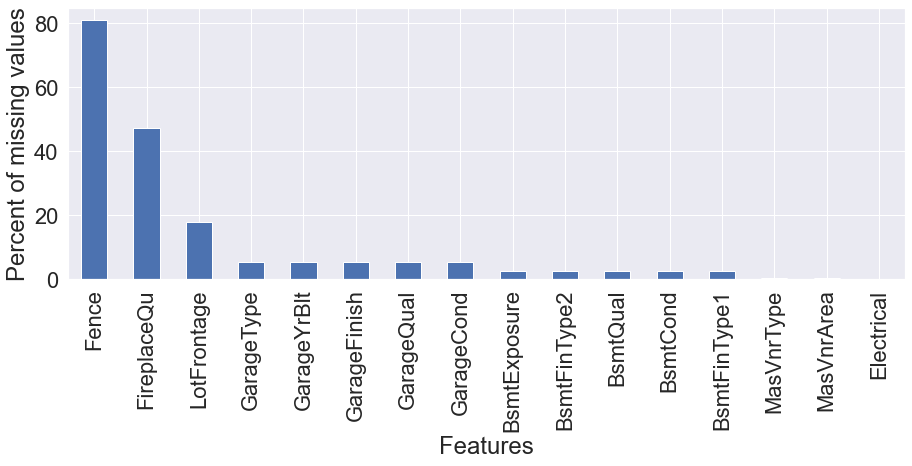

Процент пропущенных значений в столбцах
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
Fence object
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [185]:
ProcentOfMissingValue(data_train)

4. Fence Качество забора

In [186]:
data_train['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Мы не можем определить по имеющимся метрикам качество изгороди и ее существование, соответственно заменяем значения на None

In [187]:
data_train["Fence"] = data_train["Fence"].fillna("None")

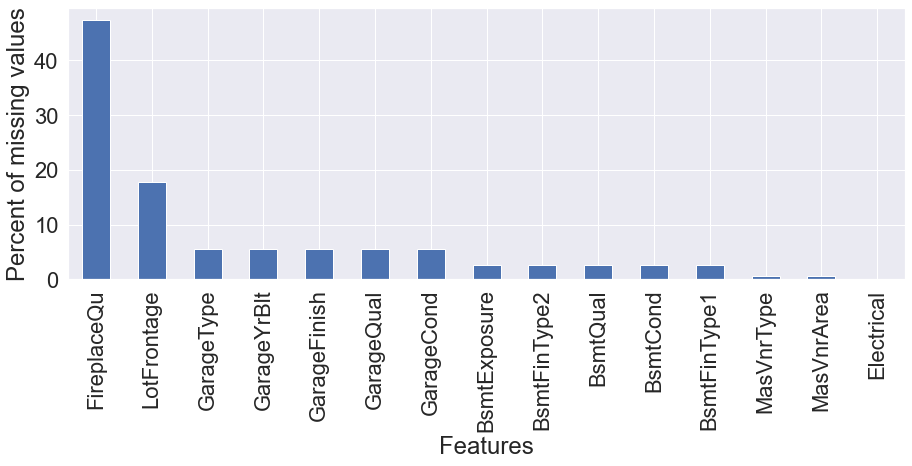

Процент пропущенных значений в столбцах
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
FireplaceQu object
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [188]:
ProcentOfMissingValue(data_train)

5. FireplaceQu Качество камина

In [189]:
data_train[['FireplaceQu','Fireplaces']]

FireplaceQu  Fireplaces
0            NaN           0
1             TA           1
2             TA           1
3             Gd           1
4             TA           1
...          ...         ...
1455          TA           1
1456          TA           2
1457          Gd           2
1458         NaN           0
1459         NaN           0

[1460 rows x 2 columns]

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Как можно понять из описания к данной переменной, если отсутствуют значения качества, то отсутствует камин, соответственном мы можем заменить на None

In [190]:
data_train["FireplaceQu"] = data_train["FireplaceQu"].fillna("None")

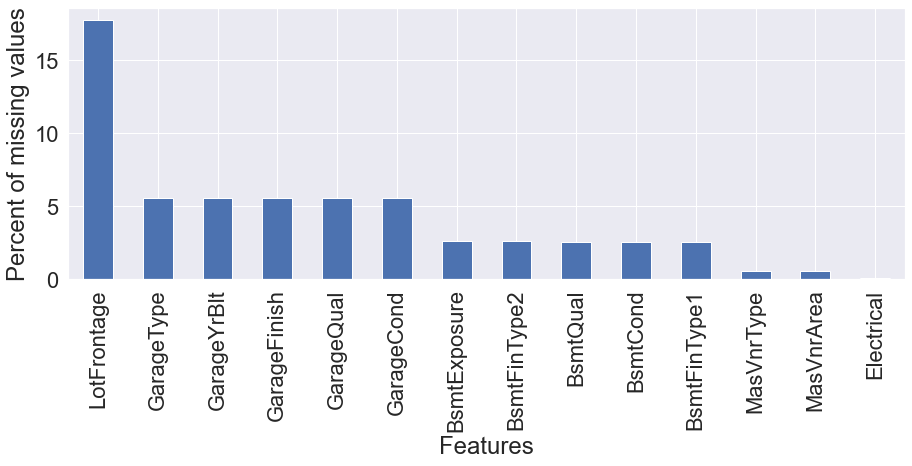

Процент пропущенных значений в столбцах
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64
------------------------------------------------
LotFrontage float64
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [191]:
ProcentOfMissingValue(data_train)

6. LotFrontage Линейные футы улицы, соединенной с недвижимостью

In [192]:
data_train['LotFrontage'].isna().sum()

259

Данная переменная имеет 259 пропущенных значений

In [193]:
data_train['LotFrontage'].head(100)

0     65.0
1     80.0
2     68.0
3     60.0
4     84.0
      ... 
95     NaN
96    78.0
97    73.0
98    85.0
99    77.0
Name: LotFrontage, Length: 100, dtype: float64

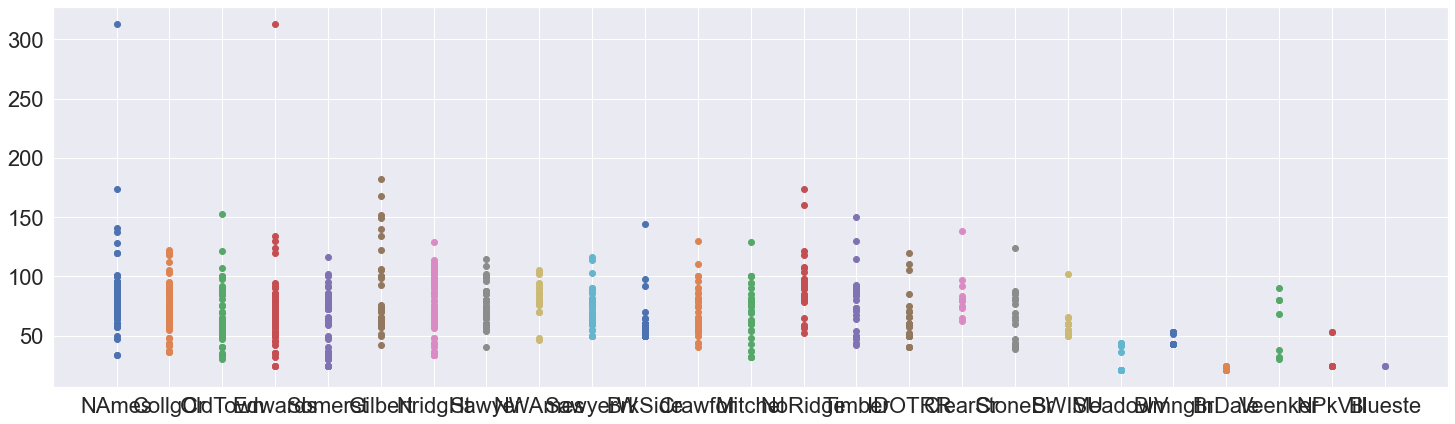

In [194]:
plt.figure(figsize=(25,7))
for i in data_train['Neighborhood'].value_counts().index:
    plt.scatter(data_train[data_train['Neighborhood'] == i]['Neighborhood'],data_train[data_train['Neighborhood'] == i]['LotFrontage'])
plt.show()
# plt.scatter(data_train[data_train['Neighborhood'] == 'NAmes']['Neighborhood'],data_train[data_train['Neighborhood'] == 'NAmes']['LotFrontage'])

Заполним средними значениями пропущенные значения в поле LotFrontage

In [195]:
data_train['Neighborhood'].value_counts().index

Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'Gilbert',
       'NridgHt', 'Sawyer', 'NWAmes', 'SawyerW', 'BrkSide', 'Crawfor',
       'Mitchel', 'NoRidge', 'Timber', 'IDOTRR', 'ClearCr', 'StoneBr', 'SWISU',
       'MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill', 'Blueste'],
      dtype='object')

In [196]:
data_train['LotFrontage'].isna().sum()

259

In [197]:
for i in data_train['Neighborhood'].value_counts().index:
    data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()

C:\Users\Nikita\AppData\Local\Temp\ipykernel_16360\46621965.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()
C:\Users\Nikita\AppData\Local\Temp\ipykernel_16360\46621965.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()
C:\Users\Nikita\AppData\Local\Temp\ipykernel_16360\46621965.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[d

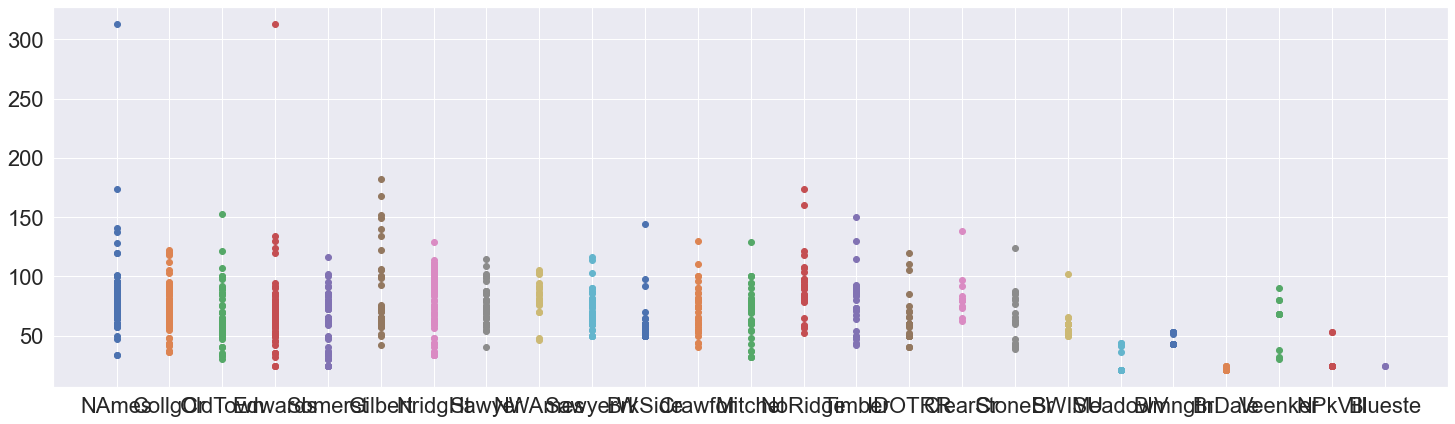

0

In [198]:
plt.figure(figsize=(25,7))
for i in data_train['Neighborhood'].value_counts().index:
    plt.scatter(data_train[data_train['Neighborhood'] == i]['Neighborhood'],data_train[data_train['Neighborhood'] == i]['LotFrontage'])
plt.show()
data_train['LotFrontage'].isna().sum()

In [199]:
data_train['LotFrontage'].head(100)

0     65.0
1     80.0
2     68.0
3     60.0
4     84.0
      ... 
95    65.0
96    78.0
97    73.0
98    85.0
99    77.0
Name: LotFrontage, Length: 100, dtype: float64

Как можно наблюдать, пропущенные данные заполнены

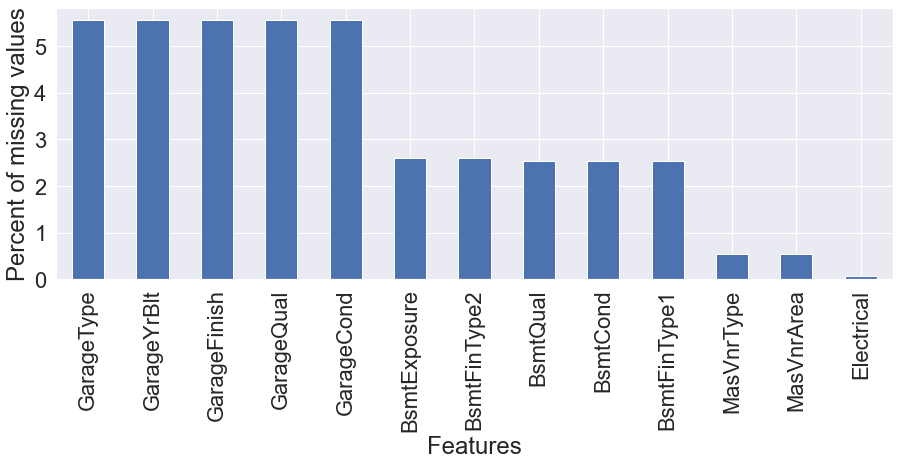

Процент пропущенных значений в столбцах
GarageType      5.547945
GarageYrBlt     5.547945
GarageFinish    5.547945
GarageQual      5.547945
GarageCond      5.547945
BsmtExposure    2.602740
BsmtFinType2    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrType      0.547945
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64
------------------------------------------------
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [200]:
ProcentOfMissingValue(data_train)

In [201]:
# test.loc[test['Neighborhood'] == 'NAmes'][test['LotFrontage'].isna() == True].index

In [202]:
# test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].median()

In [203]:
# test.loc[test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].index, 'LotFrontage'] = test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].median()

In [204]:
# test[data_train['Neighborhood'] == 'NAmes']['LotFrontage']

In [205]:
# test.loc[test[data_train['Neighborhood'] == 'BrDale']['LotFrontage'].index, 'LotFrontage']

In [206]:
# data_train.loc[test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].index, 'LotFrontage']

In [207]:
# test[data_train['Neighborhood'] == 'NAmes']['LotFrontage'].index

In [208]:
# data_train[data_train['Neighborhood'] == 'NAmes'][data_train['LotFrontage'].isna() == True]['LotFrontage'].index

7.  GarageType      Место в гараже

    GarageYrBlt     Год постройки гаража.

    GarageFinish    Внутренняя отделка гаража

    GarageQual      качество гаража

    GarageCond      Состояние гаража

In [209]:
# data_train[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].isna().

Для анализа можно использовать еще две переменных

    GarageCars: Размер гаража по вместимости автомобиля

    GarageArea: Размер гаража в квадратных футах.

In [210]:
data_train.loc[data_train[data_train['GarageCond'].isna() == True].index][['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageCars','GarageArea']]

GarageType  GarageYrBlt GarageFinish GarageQual GarageCond  GarageCars  \
39          NaN          NaN          NaN        NaN        NaN           0   
48          NaN          NaN          NaN        NaN        NaN           0   
78          NaN          NaN          NaN        NaN        NaN           0   
88          NaN          NaN          NaN        NaN        NaN           0   
89          NaN          NaN          NaN        NaN        NaN           0   
...         ...          ...          ...        ...        ...         ...   
1349        NaN          NaN          NaN        NaN        NaN           0   
1407        NaN          NaN          NaN        NaN        NaN           0   
1449        NaN          NaN          NaN        NaN        NaN           0   
1450        NaN          NaN          NaN        NaN        NaN           0   
1453        NaN          NaN          NaN        NaN        NaN           0   

      GarageArea  
39             0  
48             0  
78             0  
88             0  
89             0  
...          ...  
1349           0  
1407           0  
1449           0  
1450           0  
1453           0  

[81 rows x 7 columns]

In [211]:
# for i in data_train.loc[data_train[data_train['GarageType'].isna() == True].index]['GarageArea']:
#     print(i)

Можно увидеть, что переменная GarageArea == 0 тогда другие значения == NaN

In [212]:
data_train['GarageType'].dtype

dtype('O')

In [213]:
data_train['GarageType'] = data_train['GarageType'].fillna('None')

In [214]:
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(0)

In [215]:
data_train['GarageFinish'] = data_train['GarageFinish'].fillna('None')

In [216]:
data_train['GarageQual'] = data_train['GarageQual'].fillna('None')

In [217]:
data_train['GarageCond'] = data_train['GarageCond'].fillna('None')

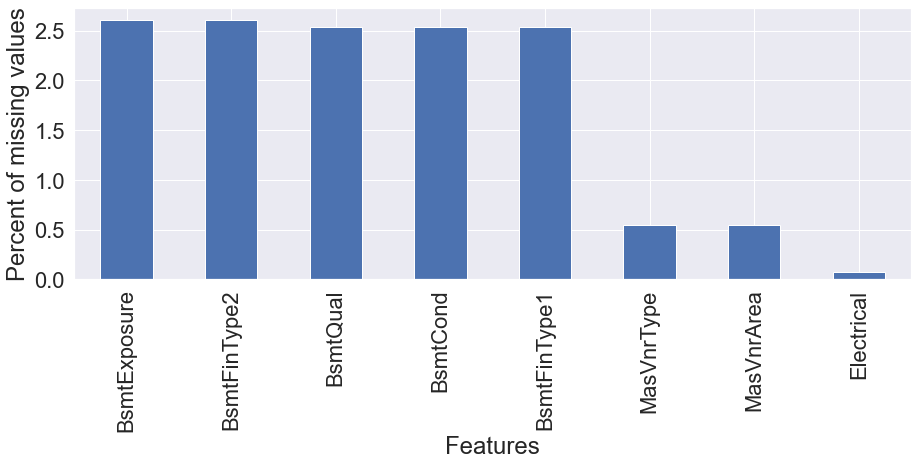

Процент пропущенных значений в столбцах
BsmtExposure    2.602740
BsmtFinType2    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrType      0.547945
MasVnrArea      0.547945
Electrical      0.068493
dtype: float64
------------------------------------------------
BsmtExposure object
BsmtFinType2 object
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
Electrical object


In [218]:
ProcentOfMissingValue(data_train)

    8.BsmtExposure Стены подвала на уровне выхода или сада.
    BsmtFinType2   Качество второй обработанной области (если присутствует)

Все значения имеющие связи с подвалом:

    BsmtQual: Высота подвала
    
    
    BsmtCond: Общее состояние подвала
    
    
    TotalBsmtSF: Общая площадь подвала в квадратных футах.
    
    
    BsmtFullBath: Ванные комнаты в подвале
    
    
    BsmtHalfBath: Половина ванных комнат в подвале
    
    

Выведим пропущенные значения и значения которые имеют связь с пропущенными значениями

In [219]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond  TotalBsmtSF  BsmtFullBath  \
17            NaN          NaN      NaN      NaN            0             0   
39            NaN          NaN      NaN      NaN            0             0   
90            NaN          NaN      NaN      NaN            0             0   
102           NaN          NaN      NaN      NaN            0             0   
156           NaN          NaN      NaN      NaN            0             0   
182           NaN          NaN      NaN      NaN            0             0   
259           NaN          NaN      NaN      NaN            0             0   
342           NaN          NaN      NaN      NaN            0             0   
362           NaN          NaN      NaN      NaN            0             0   
371           NaN          NaN      NaN      NaN            0             0   
392           NaN          NaN      NaN      NaN            0             0   
520           NaN          NaN      NaN      NaN            0             0   
532           NaN          NaN      NaN      NaN            0             0   
533           NaN          NaN      NaN      NaN            0             0   
553           NaN          NaN      NaN      NaN            0             0   
646           NaN          NaN      NaN      NaN            0             0   
705           NaN          NaN      NaN      NaN            0             0   
736           NaN          NaN      NaN      NaN            0             0   
749           NaN          NaN      NaN      NaN            0             0   
778           NaN          NaN      NaN      NaN            0             0   
868           NaN          NaN      NaN      NaN            0             0   
894           NaN          NaN      NaN      NaN            0             0   
897           NaN          NaN      NaN      NaN            0             0   
948           NaN          Unf       Gd       TA          936             0   
984           NaN          NaN      NaN      NaN            0             0   
1000          NaN          NaN      NaN      NaN            0             0   
1011          NaN          NaN      NaN      NaN            0             0   
1035          NaN          NaN      NaN      NaN            0             0   
1045          NaN          NaN      NaN      NaN            0             0   
1048          NaN          NaN      NaN      NaN            0             0   
1049          NaN          NaN      NaN      NaN            0             0   
1090          NaN          NaN      NaN      NaN            0             0   
1179          NaN          NaN      NaN      NaN            0             0   
1216          NaN          NaN      NaN      NaN            0             0   
1218          NaN          NaN      NaN      NaN            0             0   
1232          NaN          NaN      NaN      NaN            0             0   
1321          NaN          NaN      NaN      NaN            0             0   
1412          NaN          NaN      NaN      NaN            0             0   

      BsmtHalfBath  
17               0  
39               0  
90               0  
102              0  
156              0  
182              0  
259              0  
342              0  
362              0  
371              0  
392              0  
520              0  
532              0  
533              0  
553              0  
646              0  
705              0  
736              0  
749              0  
778              0  
868              0  
894              0  
897              0  
948              0  
984              0  
1000             0  
1011             0  
1035             0  
1045             0  
1048             0  
1049             0  
1090             0  
1179             0  
1216             0  
1218             0  
1232             0  
1321             0  
1412             0

Как можно видеть, практически все значения можно заполнить значениями None в связи с отсутствием подвального помещения, кроме индекса 948

Значения под индексом 948 можно заполнить изучив значения столбцов

In [220]:
data_train[(data_train['BsmtFinType2'] == 'Unf') & (data_train['BsmtQual'] == 'Gd') & (data_train['BsmtCond'] == 'TA') & (data_train['TotalBsmtSF'] > 900) & (data_train['TotalBsmtSF'] < 1000)][['BsmtExposure']].value_counts()


BsmtExposure
No              49
Mn               6
Gd               5
Av               3
dtype: int64

Были настроены фильтры по значениям (data_train['BsmtFinType2'] == 'Unf') & (data_train['BsmtQual'] == 'Gd') & (data_train['BsmtCond'] == 'TA') & (data_train['TotalBsmtSF'] > 900) & (data_train['TotalBsmtSF'] < 1000), и мы получили что наибольшая вероятность попадания значения с этими характеристиками в значение 'No'

In [221]:
data_train.loc[948,'BsmtExposure'] = 'No'

Еще раз провряем значения 

In [222]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond  TotalBsmtSF  BsmtFullBath  \
17            NaN          NaN      NaN      NaN            0             0   
39            NaN          NaN      NaN      NaN            0             0   
90            NaN          NaN      NaN      NaN            0             0   
102           NaN          NaN      NaN      NaN            0             0   
156           NaN          NaN      NaN      NaN            0             0   
182           NaN          NaN      NaN      NaN            0             0   
259           NaN          NaN      NaN      NaN            0             0   
342           NaN          NaN      NaN      NaN            0             0   
362           NaN          NaN      NaN      NaN            0             0   
371           NaN          NaN      NaN      NaN            0             0   
392           NaN          NaN      NaN      NaN            0             0   
520           NaN          NaN      NaN      NaN            0             0   
532           NaN          NaN      NaN      NaN            0             0   
533           NaN          NaN      NaN      NaN            0             0   
553           NaN          NaN      NaN      NaN            0             0   
646           NaN          NaN      NaN      NaN            0             0   
705           NaN          NaN      NaN      NaN            0             0   
736           NaN          NaN      NaN      NaN            0             0   
749           NaN          NaN      NaN      NaN            0             0   
778           NaN          NaN      NaN      NaN            0             0   
868           NaN          NaN      NaN      NaN            0             0   
894           NaN          NaN      NaN      NaN            0             0   
897           NaN          NaN      NaN      NaN            0             0   
984           NaN          NaN      NaN      NaN            0             0   
1000          NaN          NaN      NaN      NaN            0             0   
1011          NaN          NaN      NaN      NaN            0             0   
1035          NaN          NaN      NaN      NaN            0             0   
1045          NaN          NaN      NaN      NaN            0             0   
1048          NaN          NaN      NaN      NaN            0             0   
1049          NaN          NaN      NaN      NaN            0             0   
1090          NaN          NaN      NaN      NaN            0             0   
1179          NaN          NaN      NaN      NaN            0             0   
1216          NaN          NaN      NaN      NaN            0             0   
1218          NaN          NaN      NaN      NaN            0             0   
1232          NaN          NaN      NaN      NaN            0             0   
1321          NaN          NaN      NaN      NaN            0             0   
1412          NaN          NaN      NaN      NaN            0             0   

      BsmtHalfBath  
17               0  
39               0  
90               0  
102              0  
156              0  
182              0  
259              0  
342              0  
362              0  
371              0  
392              0  
520              0  
532              0  
533              0  
553              0  
646              0  
705              0  
736              0  
749              0  
778              0  
868              0  
894              0  
897              0  
984              0  
1000             0  
1011             0  
1035             0  
1045             0  
1048             0  
1049             0  
1090             0  
1179             0  
1216             0  
1218             0  
1232             0  
1321             0  
1412             0

Как можно видеть, значение под индексом 948 пропало

Остальыне значения можно заполнить None

In [223]:
index_ = data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2']].index
rows_ = ['BsmtExposure', 'BsmtFinType2']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [224]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2']]

Empty DataFrame
Columns: [BsmtExposure, BsmtFinType2]
Index: []

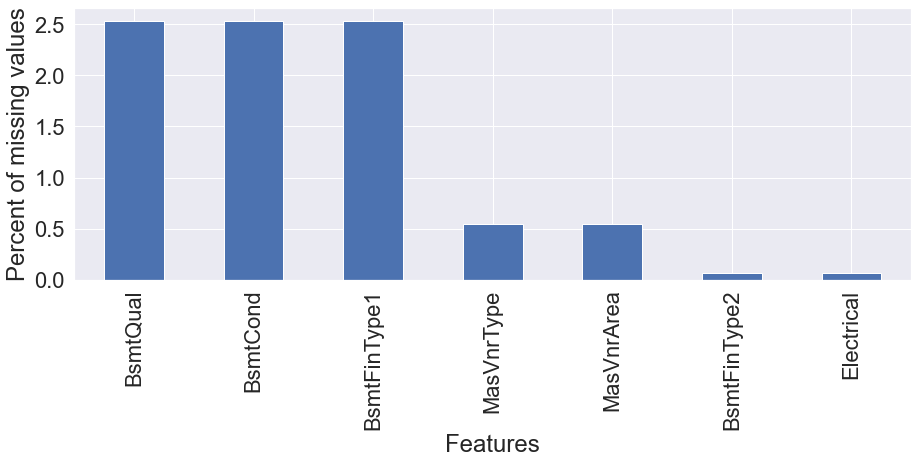

Процент пропущенных значений в столбцах
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrType      0.547945
MasVnrArea      0.547945
BsmtFinType2    0.068493
Electrical      0.068493
dtype: float64
------------------------------------------------
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
BsmtFinType2 object
Electrical object


In [225]:
ProcentOfMissingValue(data_train)

    9. BsmtQual Высота подвала
    
       BsmtCond Общее состояние подвала
    
       BsmtFinType1 Качество отделки цокольного этажа

In [226]:
data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond', 'BsmtFinType1','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  TotalBsmtSF  \
17           None         None      NaN      NaN          NaN            0   
39           None         None      NaN      NaN          NaN            0   
90           None         None      NaN      NaN          NaN            0   
102          None         None      NaN      NaN          NaN            0   
156          None         None      NaN      NaN          NaN            0   
182          None         None      NaN      NaN          NaN            0   
259          None         None      NaN      NaN          NaN            0   
342          None         None      NaN      NaN          NaN            0   
362          None         None      NaN      NaN          NaN            0   
371          None         None      NaN      NaN          NaN            0   
392          None         None      NaN      NaN          NaN            0   
520          None         None      NaN      NaN          NaN            0   
532          None         None      NaN      NaN          NaN            0   
533          None         None      NaN      NaN          NaN            0   
553          None         None      NaN      NaN          NaN            0   
646          None         None      NaN      NaN          NaN            0   
705          None         None      NaN      NaN          NaN            0   
736          None         None      NaN      NaN          NaN            0   
749          None         None      NaN      NaN          NaN            0   
778          None         None      NaN      NaN          NaN            0   
868          None         None      NaN      NaN          NaN            0   
894          None         None      NaN      NaN          NaN            0   
897          None         None      NaN      NaN          NaN            0   
984          None         None      NaN      NaN          NaN            0   
1000         None         None      NaN      NaN          NaN            0   
1011         None         None      NaN      NaN          NaN            0   
1035         None         None      NaN      NaN          NaN            0   
1045         None         None      NaN      NaN          NaN            0   
1048         None         None      NaN      NaN          NaN            0   
1049         None         None      NaN      NaN          NaN            0   
1090         None         None      NaN      NaN          NaN            0   
1179         None         None      NaN      NaN          NaN            0   
1216         None         None      NaN      NaN          NaN            0   
1218         None         None      NaN      NaN          NaN            0   
1232         None         None      NaN      NaN          NaN            0   
1321         None         None      NaN      NaN          NaN            0   
1412         None         None      NaN      NaN          NaN            0   

      BsmtFullBath  BsmtHalfBath  
17               0             0  
39               0             0  
90               0             0  
102              0             0  
156              0             0  
182              0             0  
259              0             0  
342              0             0  
362              0             0  
371              0             0  
392              0             0  
520              0             0  
532              0             0  
533              0             0  
553              0             0  
646              0             0  
705              0             0  
736              0             0  
749              0             0  
778              0             0  
868              0             0  
894              0             0  
897              0             0  
984              0             0  
1000             0             0  
1011             0             0  
1035             0             0  
1045             0             0  
1048             0       

Как можно видеть, все значения можно заменить на None

In [227]:
index_ = data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index].index
rows_ = ['BsmtQual', 'BsmtCond','BsmtFinType1']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [228]:
data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond', 'BsmtFinType1','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

Empty DataFrame
Columns: [BsmtExposure, BsmtFinType2, BsmtQual, BsmtCond, BsmtFinType1, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

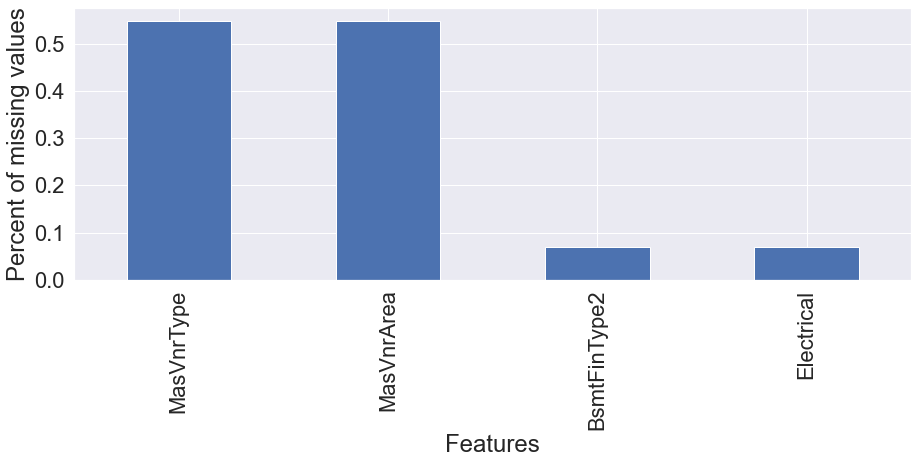

Процент пропущенных значений в столбцах
MasVnrType      0.547945
MasVnrArea      0.547945
BsmtFinType2    0.068493
Electrical      0.068493
dtype: float64
------------------------------------------------
MasVnrType object
MasVnrArea float64
BsmtFinType2 object
Electrical object


In [229]:
ProcentOfMissingValue(data_train)

    10. MasVnrType Тип каменной кладки
        MasVnrArea Площадь каменной кладки в квадратных футах.

In [230]:
index_ = data_train.loc[data_train[(data_train['MasVnrType'].isna() == True) & (data_train['MasVnrArea'].isna() == True)].index][['MasVnrType','MasVnrArea']].index
rows_ = ['MasVnrType']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [231]:
data_train['MasVnrType'].value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [232]:
index_ = data_train.loc[data_train[(data_train['MasVnrArea'].isna() == True)].index][['MasVnrArea']].index
rows_ = ['MasVnrArea']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna(0)

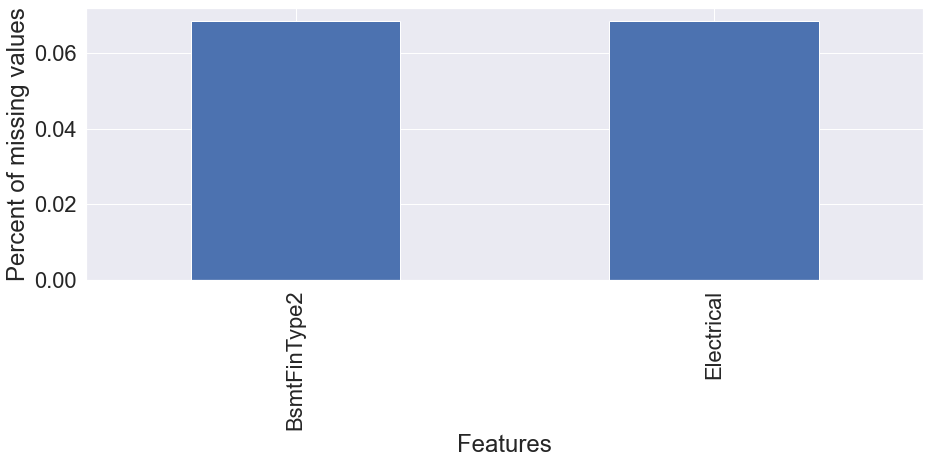

Процент пропущенных значений в столбцах
BsmtFinType2    0.068493
Electrical      0.068493
dtype: float64
------------------------------------------------
BsmtFinType2 object
Electrical object


In [233]:
ProcentOfMissingValue(data_train)

    11. BsmtFinType2 Качество второй обработанной области (если присутствует)
    Electrical Электрическая система

In [234]:
data_train.loc[data_train[(data_train['BsmtFinType2'].isna() == True)|(data_train['Electrical'].isna() == True)].index][['BsmtFinType2','Electrical']]
# data_train[['BsmtFinType2','Electrical']]

BsmtFinType2 Electrical
332           NaN      SBrkr
1379          Unf        NaN

In [235]:
data_train[data_train['BsmtFinType2'] == 'Unf'][['BsmtFinType2','Electrical']].value_counts()

BsmtFinType2  Electrical
Unf           SBrkr         1153
              FuseA           79
              FuseF           20
              FuseP            2
              Mix              1
dtype: int64

In [236]:
index_ = data_train.loc[data_train[(data_train['Electrical'].isna() == True)].index][['Electrical']].index
print(index_)
rows_ = ['Electrical']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('SBrkr')

Int64Index([1379], dtype='int64')


In [237]:
data_train.loc[1379,'Electrical']

'SBrkr'

In [238]:
data_train[data_train['Electrical'] == 'SBrkr'][['BsmtFinType2','Electrical']].value_counts()

BsmtFinType2  Electrical
Unf           SBrkr         1154
Rec           SBrkr           50
LwQ           SBrkr           45
BLQ           SBrkr           29
None          SBrkr           24
ALQ           SBrkr           18
GLQ           SBrkr           14
dtype: int64

In [239]:
index_ = data_train.loc[data_train[(data_train['BsmtFinType2'].isna() == True)].index][['BsmtFinType2']].index
print(index_)
rows_ = ['BsmtFinType2']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('Unf')

Int64Index([332], dtype='int64')


In [240]:
data_train.loc[332,'BsmtFinType2']

'Unf'

Проверяем на наличие пропущенных значений

In [241]:
data_train.isna().sum().sum()

0

Мы получили чистый датасет, без пропущенных значений

**Описание наименований столбцов**
- SalePrice: цена продажи недвижимости в долларах. Это целевая переменная, которую вы пытаетесь предсказать.
- MSSubClass: класс здания
- MSZoning: Общая классификация зонирования
- LotFrontage: Линейные футы улицы, соединенной с недвижимостью
- LotArea: Размер участка в квадратных футах.
- Улица: Тип подъездной дороги
- Аллея: Тип доступа к аллее
- LotShape: Общий вид недвижимости
- LandContour: Плоскостность объекта
- Утилиты: Тип доступных утилит
- LotConfig: конфигурация лота
- LandSlope: уклон участка
- Окрестности: физические местоположения в черте города Эймс.
- Условие 1: Близость к главной дороге или железной дороге
- Условие 2: близость к главной дороге или железной дороге (при наличии второй)
- BldgType: Тип жилья
- HouseStyle: стиль жилья
- Общее качество: общее качество материала и отделки.
- TotalCond: общая оценка состояния
- Год постройки: Первоначальная дата постройки
- YearRemodAdd: дата переделки
- RoofStyle: тип крыши
- RoofMatl: Материал крыши
- Exterior1st: Внешнее покрытие дома
- Exterior2nd: Внешнее покрытие дома (если более одного материала)
- MasVnrType: Тип каменной кладки
- MasVnrArea: Площадь каменной кладки в квадратных футах.
- ExterQual: качество материалов экстерьера
- ExterCond: Текущее состояние материала снаружи.
- Фундамент: Тип фундамента
- BsmtQual: Высота подвала
- BsmtCond: Общее состояние подвала
- BsmtExposure: Стены подвала на уровне выхода или сада.
- BsmtFinType1: Качество отделки цокольного этажа
- BsmtFinSF1: тип 1 с отделкой в квадратных футах
- BsmtFinType2: Качество второй обработанной области (если присутствует)
- BsmtFinSF2: тип 2 с отделкой в квадратных футах
- BsmtUnfSF: Незавершенные квадратные футы цокольного этажа.
- TotalBsmtSF: Общая площадь подвала в квадратных футах.
- Отопление: Тип отопления
- ОтоплениеQC: Качество и состояние отопления
- CentralAir: центральное кондиционирование
- Электрика: Электрическая система
- 1stFlrSF: квадратные футы первого этажа
- 2ndFlrSF: Квадратные футы второго этажа.
- LowQualFinSF: квадратные футы с отделкой низкого качества (все этажи)
- GrLivArea: жилая площадь над землей в квадратных футах
- BsmtFullBath: Ванные комнаты в подвале
- BsmtHalfBath: Половина ванных комнат в подвале
- FullBath: полностью оборудованные ванные комнаты выше уровня земли.
- HalfBath: полуванны выше уровня
- Спальня: Количество спален выше цокольного этажа
- Кухня: Количество кухонь
- KitchenQual: Качество кухни
- TotRmsAbvGrd: Общее количество комнат выше класса (не включая ванные комнаты)
- Функциональность: рейтинг домашней функциональности
- Камины: Количество каминов
- FireplaceQu: качество камина
- GarageType: Место в гараже
- GarageYrBlt: Год постройки гаража.
- GarageFinish: Внутренняя отделка гаража
- GarageCars: Размер гаража по вместимости автомобиля
- GarageArea: Размер гаража в квадратных футах.
- GarageQual: качество гаража
- GarageCond: Гаражное состояние
- PavedDrive: Асфальтированная дорога
- WoodDeckSF: площадь деревянной палубы в квадратных футах.
- OpenPorchSF: площадь открытого крыльца в квадратных футах.
- EnclosedPorch: закрытая площадь крыльца в квадратных футах.
- 3SsnPorch: площадь крыльца для трех сезонов в квадратных футах.
- ScreenPorch: Площадь крыльца в квадратных футах.
- PoolArea: Площадь бассейна в квадратных футах.
- PoolQC: качество пула
- Забор: Качество забора
- MiscFeature: Разная функция, не включенная в другие категории.
- MiscVal: Значение различных функций
- MoSold: месяц продажи
- Год продажи: Год продажи
- SaleType: Тип продажи
- Состояние продажи: Состояние продажи

**Строим диаграмму распределений исходного датасета и проводим описание данных**

Рисунок № 1. Диаграмма распределений значений цены

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


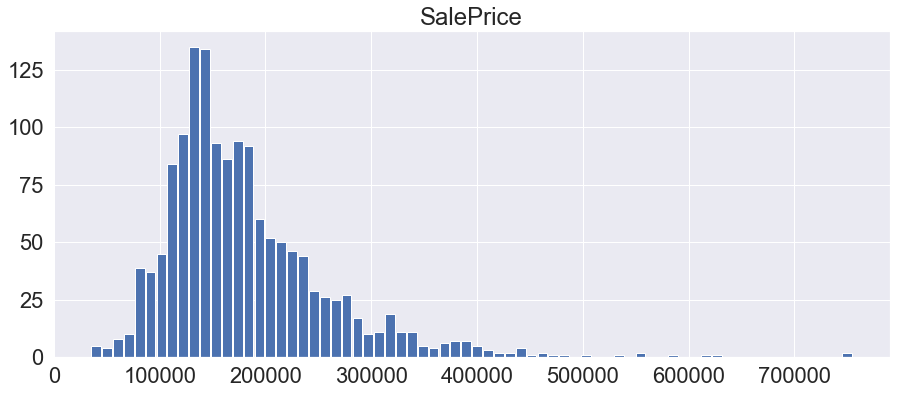

In [242]:
data_train.hist(column = 'SalePrice', bins = 70,figsize=(15,6), zorder=2, rwidth=0.9)
print(data_train['SalePrice'].describe())

**Строим диаграмму размаха цены исходного датасета**

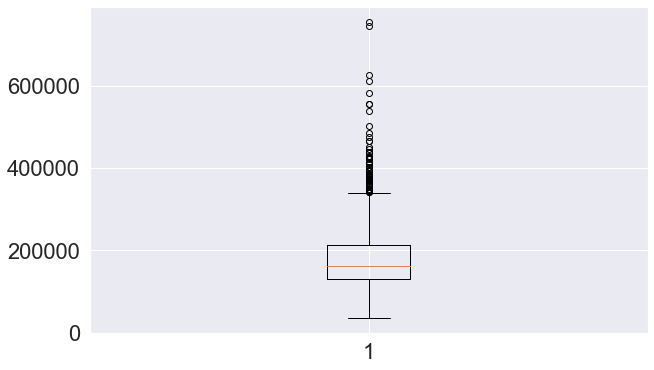

In [243]:
plt.figure(figsize=(10,6))
plt.boxplot(x=data_train['SalePrice'])
plt.show()

**Строим диаграмму рассеивания**

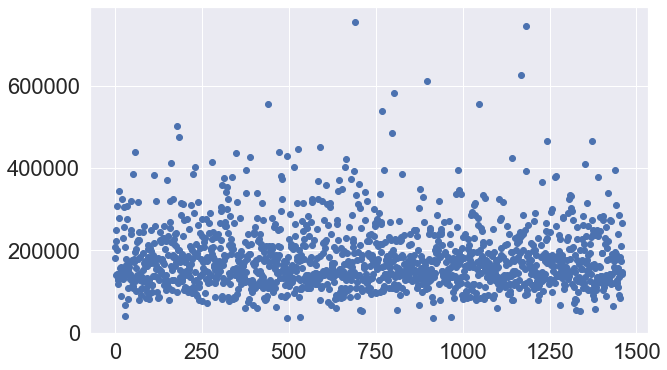

In [244]:
plt.figure(figsize=(10,6))
plt.scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
plt.show()

**Определяем типы данных присутствующие в датасете**

In [245]:
print('В датафрейме содержатся типы данных: ', data_train.dtypes.unique())
print('Количество столбцов типа int64: ', data_train.dtypes[data_train.dtypes == 'int64'].count())
print('Количество столбцов типа objects (O) : ', data_train.dtypes[data_train.dtypes == 'O'].count())
print('Количество столбцов типа float64 : ', data_train.dtypes[data_train.dtypes == 'float64'].count())

В датафрейме содержатся типы данных:  [dtype('int64') dtype('O') dtype('float64')]
Количество столбцов типа int64:  34
Количество столбцов типа objects (O) :  43
Количество столбцов типа float64 :  3


**Преобразование катигориальных данных в цифровые**

В связи с тем, что имы имеем катигориальные данные, а нейронные сети работают с цифрами, необходимо произвести их преобразование

In [246]:
ctr = 0
for i in data_train.dtypes[data_train.dtypes == 'O'].index:
    ctr = ctr + len(data_train[i].value_counts().index)
print('После преобразования мы должны получить количество столбцов: ', len(data_train.columns) - len(data_train.dtypes[data_train.dtypes == 'O'].index) + ctr)

После преобразования мы должны получить количество столбцов:  303


In [247]:
# Функция преобразования категориальных значений в цифровые
def ConvertCatToNum(data):
    data_ = data
    if(data.dtypes[data.dtypes == 'O'].count() == 0):
        return data
    if(data.dtypes[data.dtypes == 'O'].count() > 0):
        index = data.dtypes[data.dtypes == 'O'].index.tolist()
        for i in index:
#             futurs = 
#             futurs = pd.get_dummies(data[i]).reset_index(drop=True)
            data_ = pd.concat([data_,
                   pd.get_dummies(data_[i], prefix = i).reset_index(drop=True)],
                  axis = 1)
            data_ = data_.drop(i,axis=1)
        return data_

In [248]:
data_train = ConvertCatToNum(data_train)

На выходе мы получаем преобразованные катигориальные данные, добавленные к существующему датфрейму и удаленные столбцы катигориальных данных.

**Проверяем сохранность количества строк**

In [249]:
data_train

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

Как можно увидеть, количество строк совпадает

**Проверяем на наличие столбцов с типом object**

In [250]:
print('В датафрейме содержатся типы данных: ', data_train.dtypes.unique())

В датафрейме содержатся типы данных:  [dtype('int64') dtype('float64') dtype('uint8')]


В датафрейме отсутствуют типы данных object

**Проверяем корреляцию между выходной переменной и входными (измерение влияния факторов на выходную переменную)**

**Производим отбор переменных (признаков**

Отличная статья: https://loginom.ru/blog/feature-selection

В данной работе был выбран метод использующий корреляцию между входными переменными и выходной. 

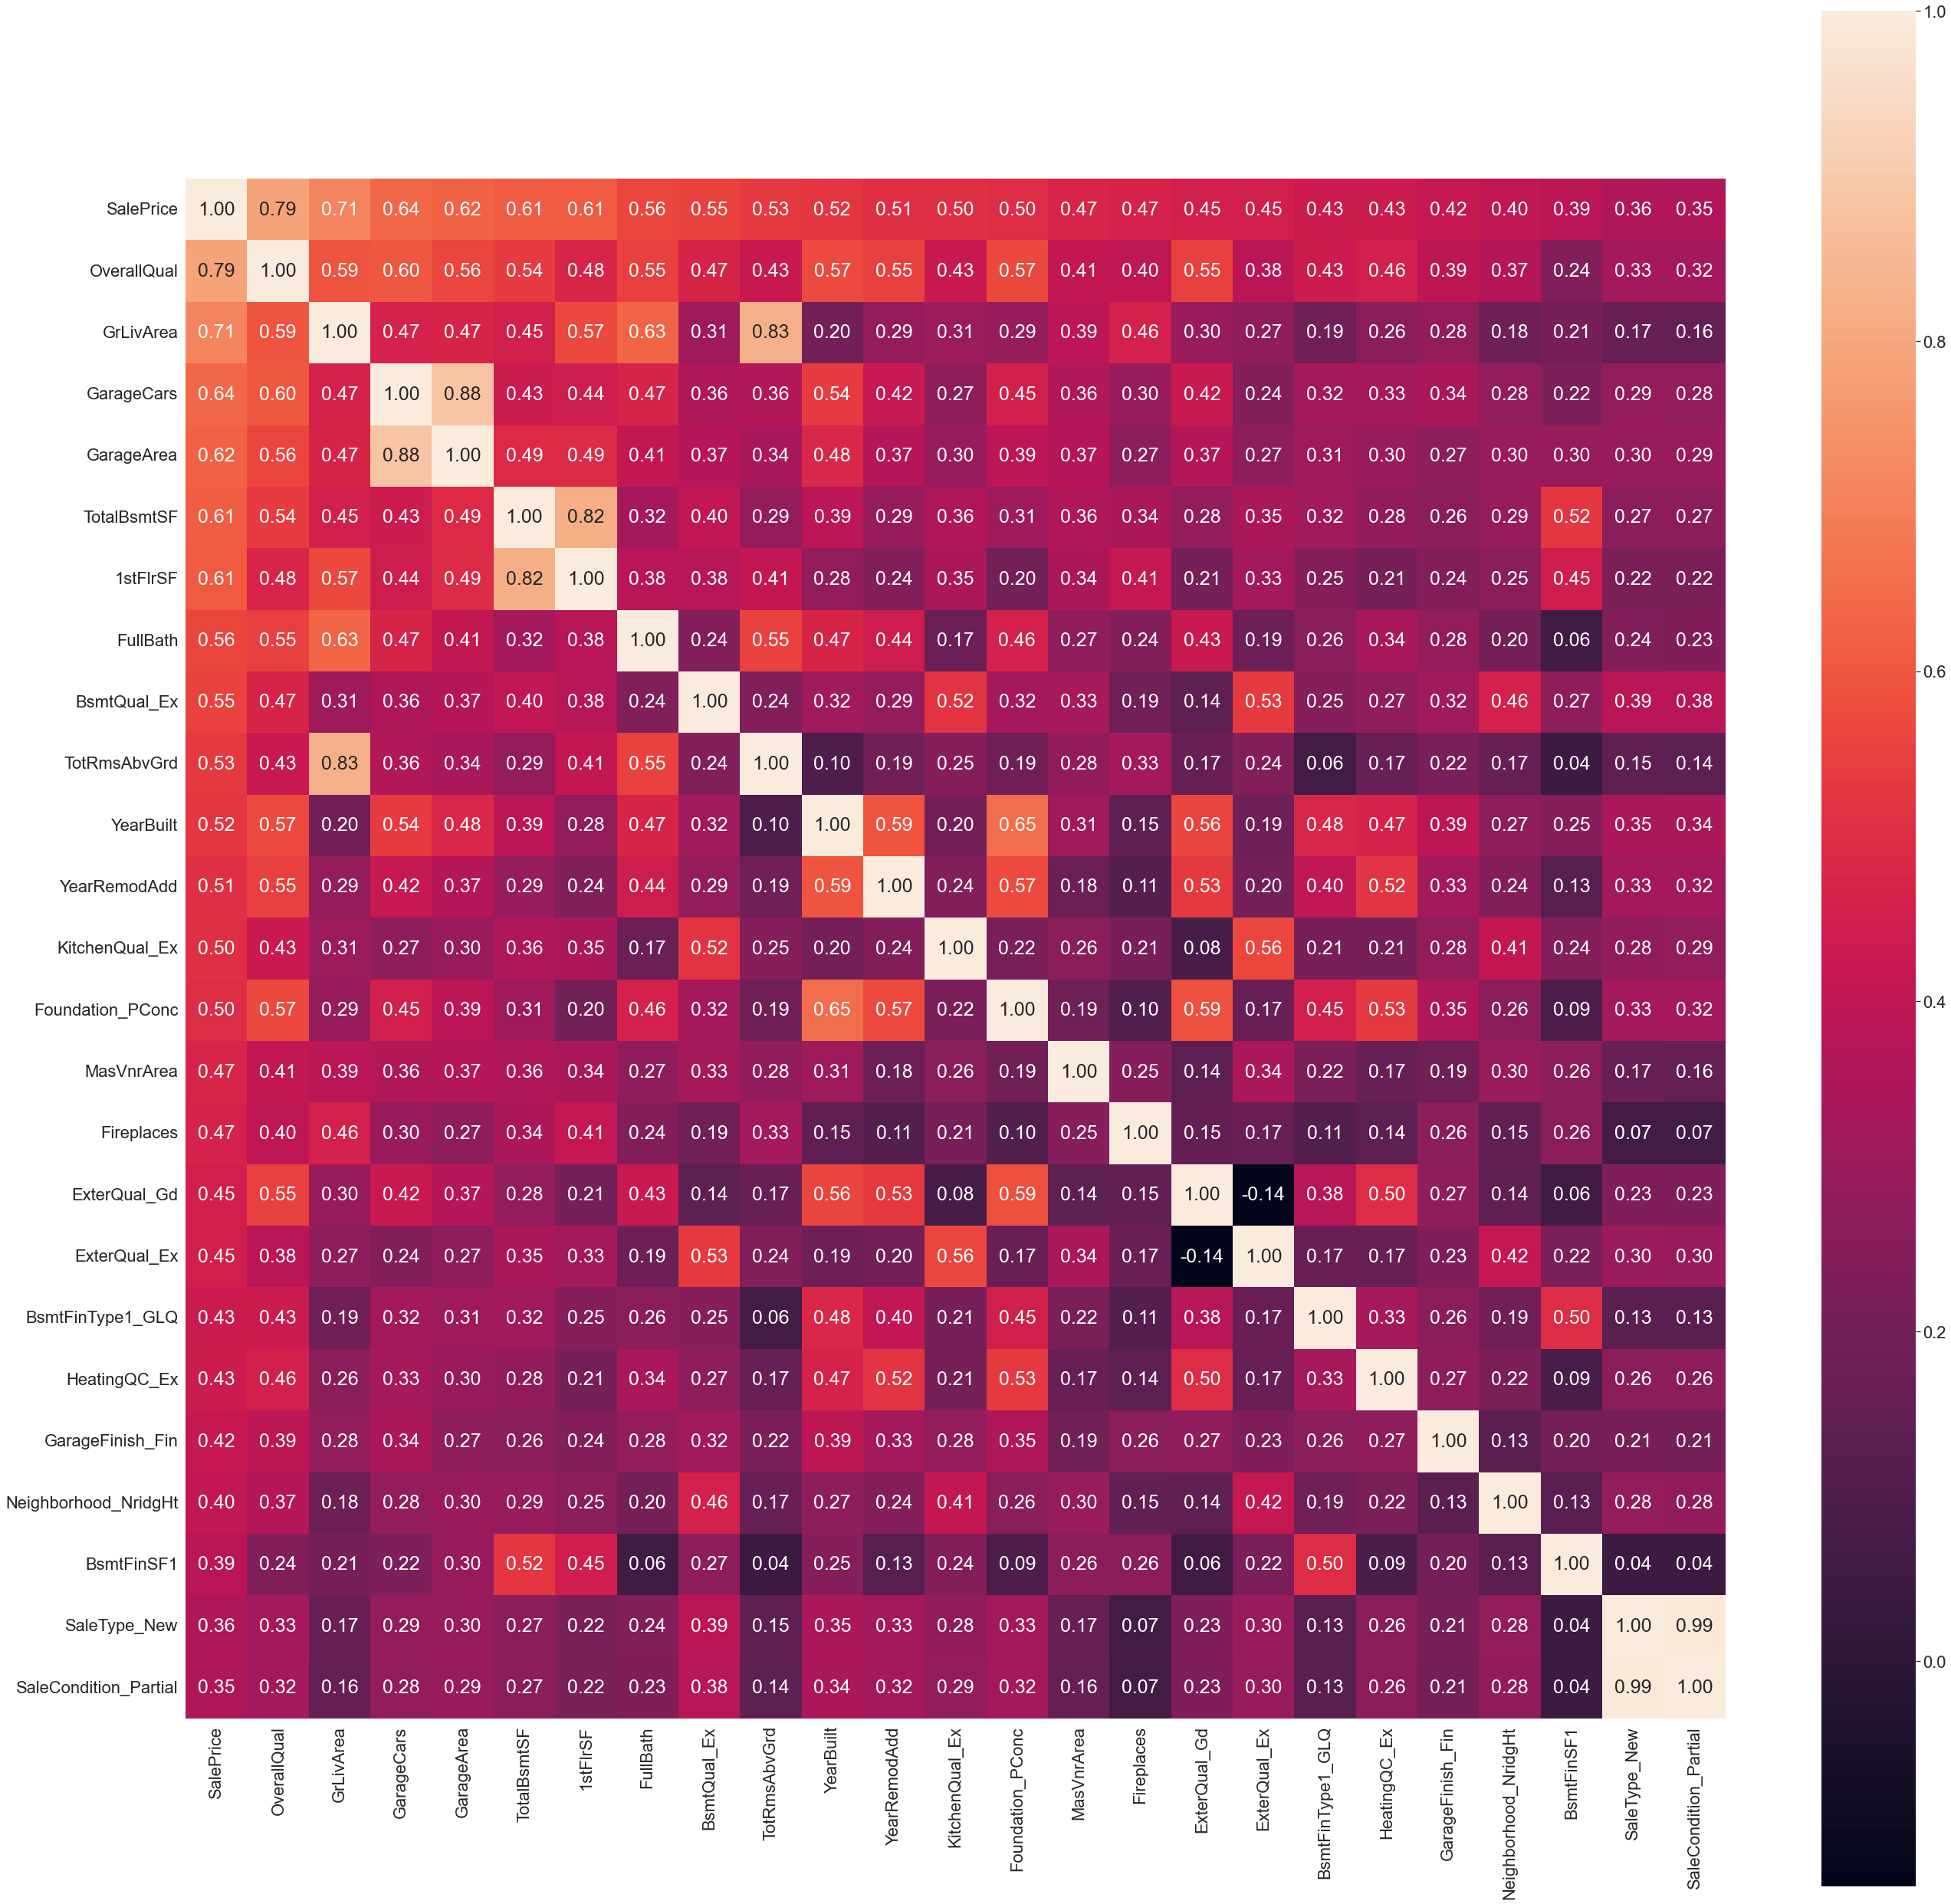

In [251]:
corrmat = data_train.corr()
k = 25 # количество коррелирующих признаков, которое мы хотим увидеть
corrmat.nlargest(k, 'SalePrice').index #Отображаем столбцы максимальной корреляции по возрастанию
cols = corrmat.nlargest(k, 'SalePrice').index
cm = np.corrcoef(data_train[cols].values.T)
plt.figure(figsize=(k+20,k+20))
sns.set(font_scale=2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 25}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Строим графики расределений максимально коррелиремых значений с ценой, а также диаграмму размаха для каждого значения**

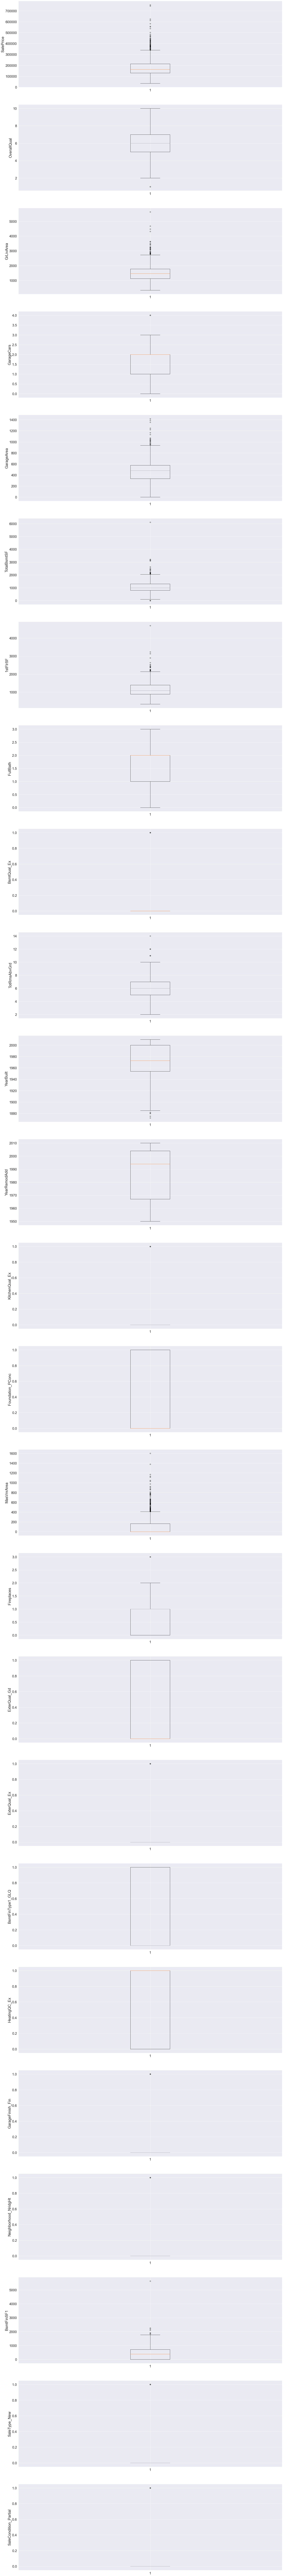

In [252]:
# fig, axs = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,300))
# for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
#     axs[ctn].scatter(data_train['SalePrice'], data_train[i])
#     axs[ctn].set_xlabel('SalePrice')
#     axs[ctn].set_ylabel(i)

fig_1, axs_1 = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,300))
for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
    axs_1[ctn].boxplot(data_train[i])
    axs_1[ctn].set_ylabel(i)

plt.show()

Можно наблюдать, что данные имеют большое количество выбросов. Соответстенно необходимо реализовать их фильтрацию, обратившись к рисунку № 1, можно заметить, что распределение имеет не симметричные хвосты, соответственно мы не може применять **метод стандартного отклонения**. По этому было принято решение использовать **Метод интерквартильных расстояний**.
Для реализации данного метода, нам необходимо найти первый (Q1) и третий (Q3) квартил, и на основе них найти "экстримальные" значения по формулам: Limmax = Q3 + Ni х IQR; Limmin = Q1 - Ni х IQR; где Q3 - третий квартиль, Q1 - первый квартиль, IQR - интерквартильное расстояние определяемое по формуле IQR = Q3 - Q1; Ni - заданное число интерквартильного размаха (1.5).

**Производим метод интерквартильных расстояний и фильтруем данные**

In [86]:
# for ctr, i in enumerate(data_train[corrmat.nlargest(k, 'SalePrice').index.drop('SalePrice')].columns):
#     Q1 = q1(data_train[i])
#     Q3 = q3(data_train[i])
#     IQR = Q3 - Q1
#     min_ = Q1 - 1.5 * IQR
#     max_ = Q3 + 1.5 * IQR
#     data_train.hist(column = i, bins = 10,figsize=(15,6), zorder=2, rwidth=0.9)
# #     data_train = data_train.drop(data_train[((data_train[i] > min_) & (data_train[i] < max_))].index)
#     print(i, '-' , 'Q1: ',Q1, ';', 'Q3: ', Q3,';', 'IQR:', IQR, ';' ,'min:', abs(Q1 - 1.5*IQR),'max:', abs(Q3 + 1.5*IQR))



**Ручная подготовка данных**

Очистка SalePrice

In [93]:
#Функция рассчета первого квартиля
def q1(x):
    return np.quantile(x, 0.25 )
#Функция рассчета второго квартиля
def q3(x):
    return np.quantile(x, 0.75)

Q1 = q1(data_train['SalePrice'])
Q3 = q3(data_train['SalePrice'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('SalePrice Q1', Q1)
print('SalePrice Q3', Q3)
print('SalePrice IQR', IQR)
print('SalePrice min', min_)
print('SalePrice max', max_)
# data_train = data_train.drop(data_train[((data_train['SalePrice'] > min_) & (data_train['SalePrice'] < max_))].index)



SalePrice Q1 128000.0
SalePrice Q3 197000.0
SalePrice IQR 69000.0
SalePrice min 24500.0
SalePrice max 300500.0


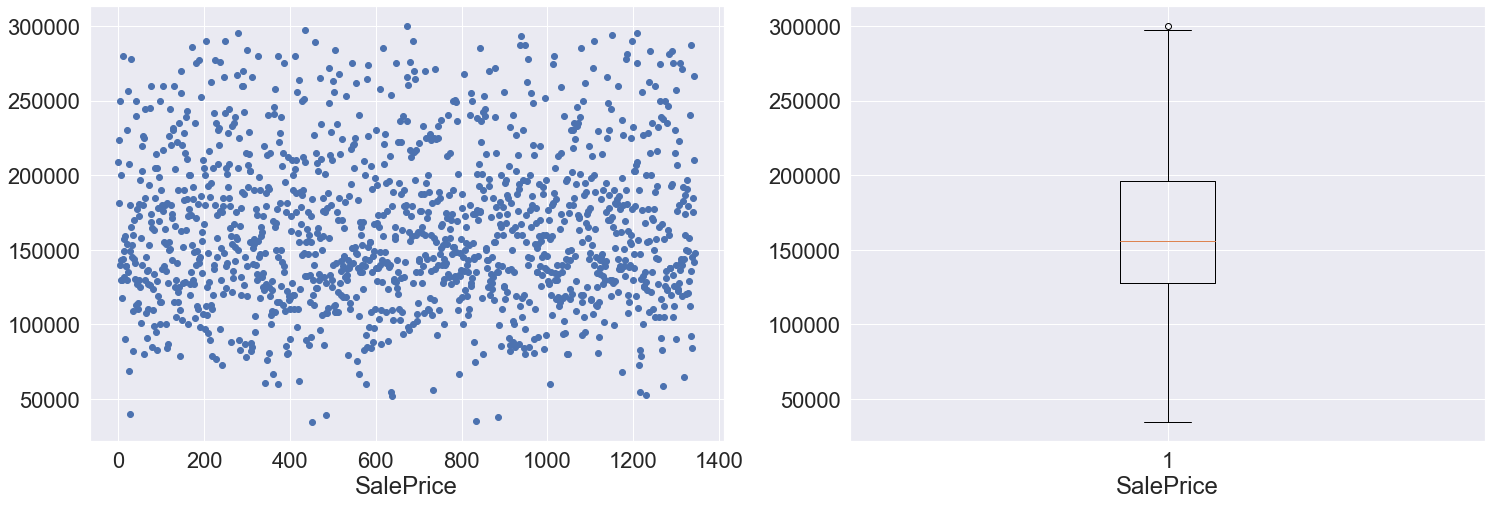

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [94]:
data_train = data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 2 ,figsize=(25,8))

aix[0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[1].boxplot(data_train['SalePrice'])
aix[0].set_xlabel('SalePrice')
aix[1].set_xlabel('SalePrice')
plt.show()
data_train

Очистка OverallQual

In [1289]:
Q1 = q1(data_train['OverallQual'])
Q3 = q3(data_train['OverallQual'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('OverallQual Q1', Q1)
print('OverallQual Q3', Q3)
print('OverallQual IQR', IQR)
print('OverallQual min', min_)
print('OverallQual max', max_)

OverallQual Q1 5.0
OverallQual Q3 7.0
OverallQual IQR 2.0
OverallQual min 2.0
OverallQual max 10.0


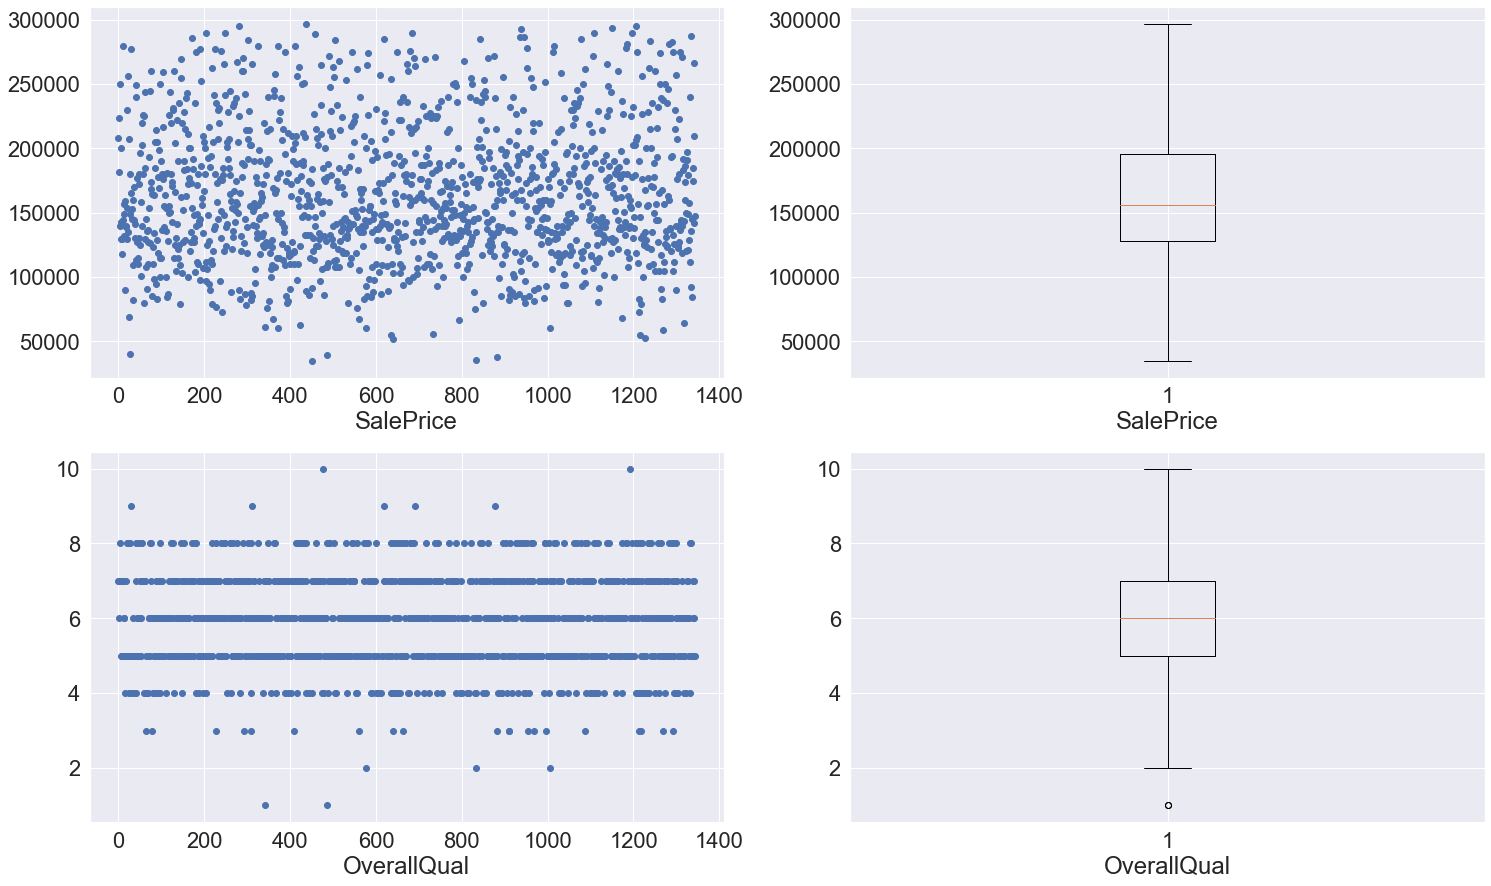

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [1290]:
data_train = data_train.drop(data_train[((max_ < data_train['OverallQual'])) & ((data_train['OverallQual'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['OverallQual'].size)),
                       y = data_train['OverallQual'].tolist())
aix[1,0].set_xlabel('OverallQual')
aix[1,1].boxplot(data_train['OverallQual'])
aix[1,1].set_xlabel('OverallQual')
plt.show()
data_train

Очистка GrLivArea

In [98]:
Q1 = q1(data_train['GrLivArea'])
Q3 = q3(data_train['GrLivArea'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GrLivArea Q1', Q1)
print('GrLivArea Q3', Q3)
print('GrLivArea IQR', IQR)
print('GrLivArea min', min_)
print('GrLivArea max', max_)

GrLivArea Q1 1110.0
GrLivArea Q3 1708.0
GrLivArea IQR 598.0
GrLivArea min 213.0
GrLivArea max 2605.0


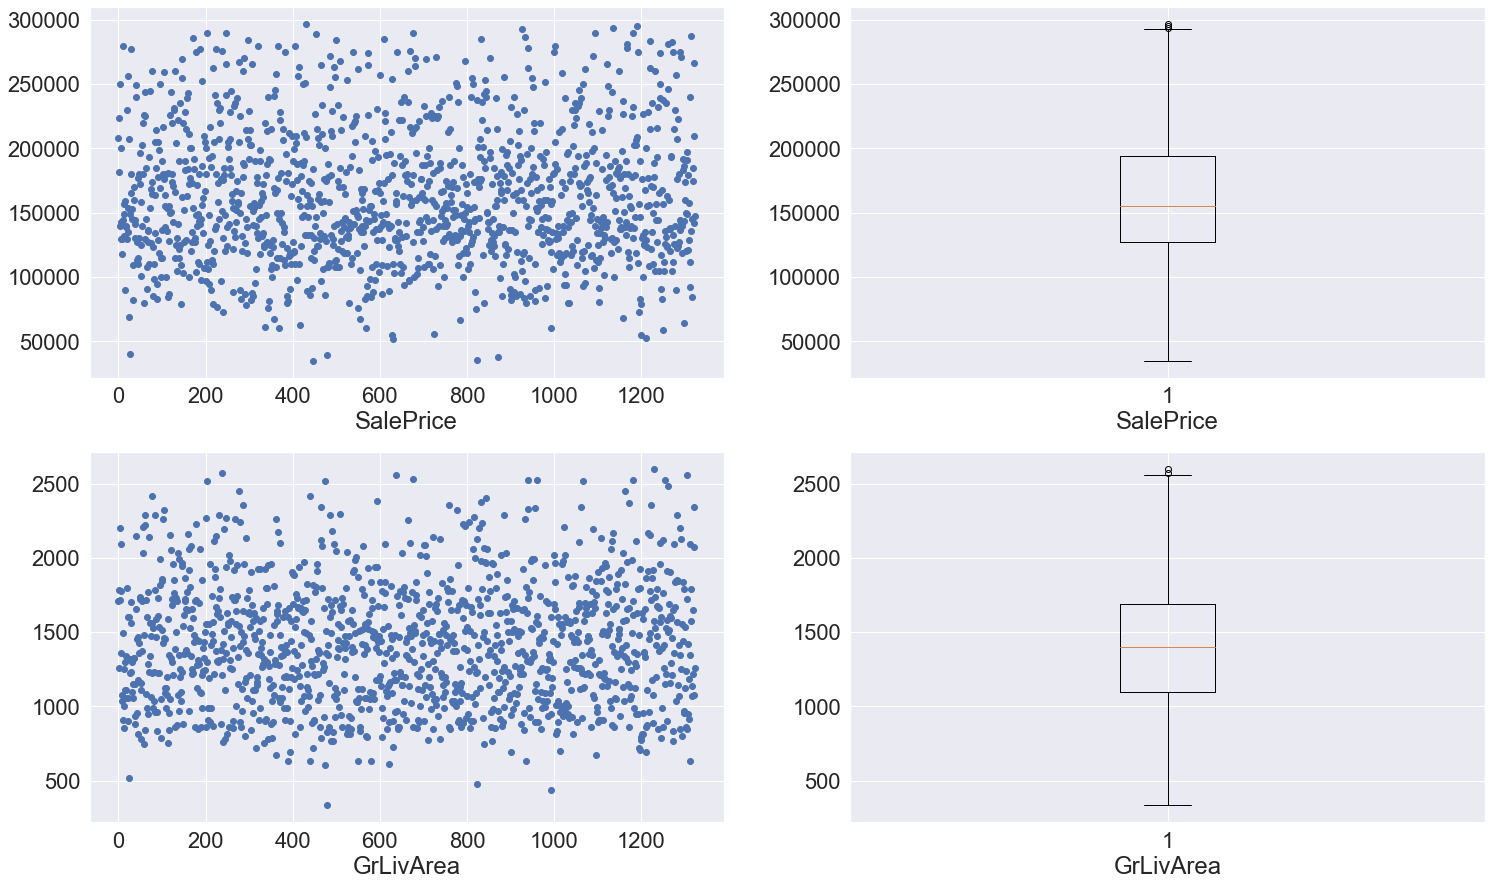

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [99]:
data_train = data_train.drop(data_train[((max_ < data_train['GrLivArea'])) & ((data_train['GrLivArea'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['GrLivArea'].size)),
                       y = data_train['GrLivArea'].tolist())
aix[1,0].set_xlabel('GrLivArea')
aix[1,1].boxplot(data_train['GrLivArea'])
aix[1,1].set_xlabel('GrLivArea')
plt.show()
data_train

Очистка GarageCars

In [1293]:
# list(data_train[corrmat.nlargest(k, 'SalePrice').index].columns)

In [101]:
Q1 = q1(data_train['GarageCars'])
Q3 = q3(data_train['GarageCars'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GarageCars Q1', Q1)
print('GarageCars Q3', Q3)
print('GarageCars IQR', IQR)
print('GarageCars min', min_)
print('GarageCars max', max_)

GarageCars Q1 1.0
GarageCars Q3 2.0
GarageCars IQR 1.0
GarageCars min -0.5
GarageCars max 3.5


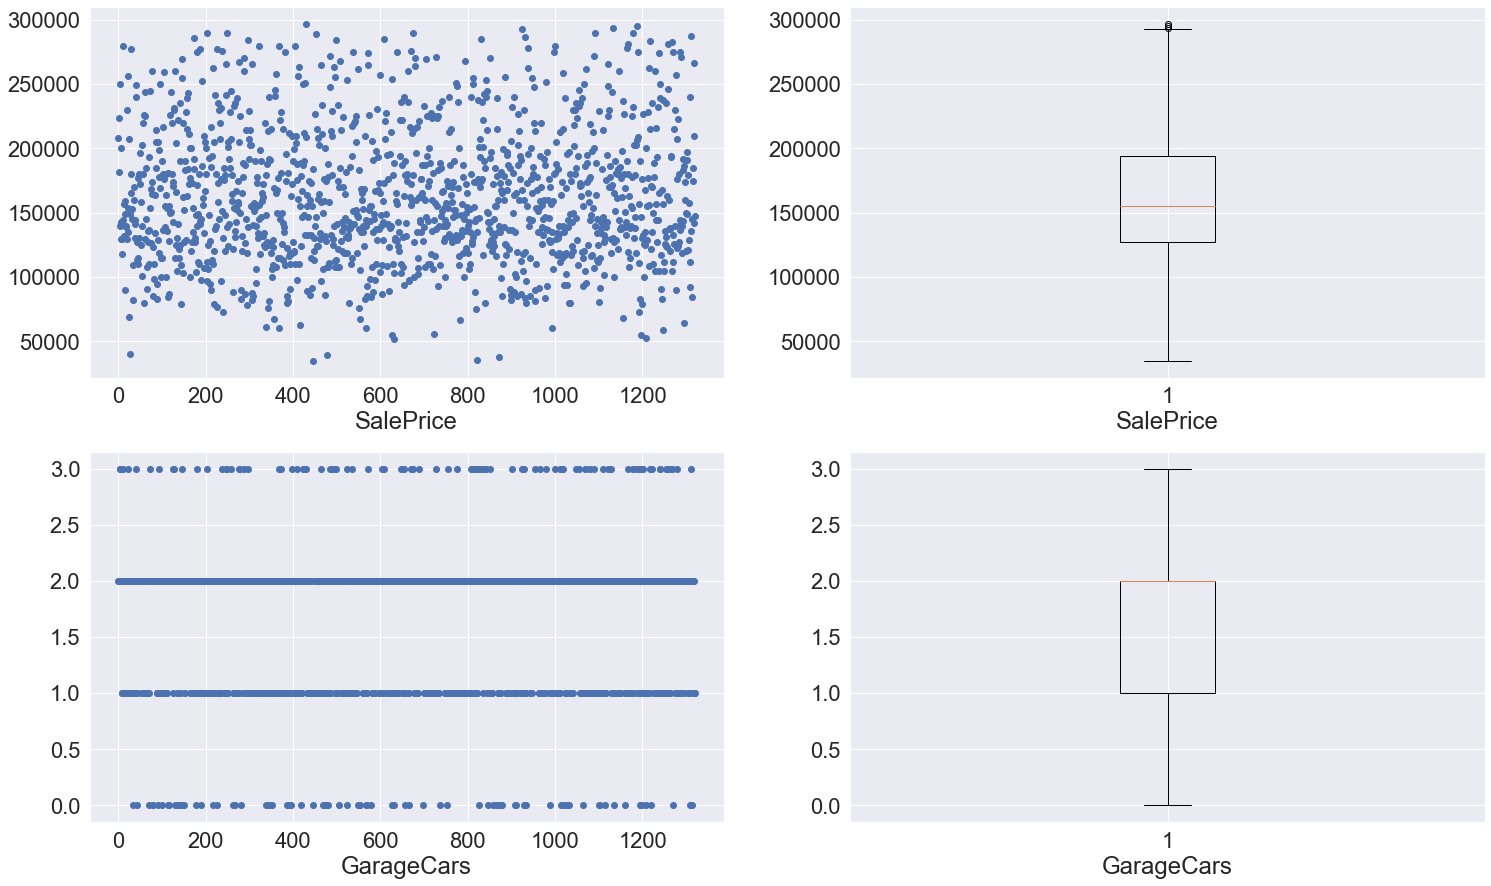

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [102]:
data_train = data_train.drop(data_train[((max_ < data_train['GarageCars'])) & ((data_train['GarageCars'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['GarageCars'].size)),
                       y = data_train['GarageCars'].tolist())
aix[1,0].set_xlabel('GarageCars')
aix[1,1].boxplot(data_train['GarageCars'])
aix[1,1].set_xlabel('GarageCars')
plt.show()
data_train

Очистка GarageArea

In [103]:
Q1 = q1(data_train['GarageArea'])
Q3 = q3(data_train['GarageArea'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GarageArea Q1', Q1)
print('GarageArea Q3', Q3)
print('GarageArea IQR', IQR)
print('GarageArea min', min_)
print('GarageArea max', max_)

GarageArea Q1 308.0
GarageArea Q3 551.0
GarageArea IQR 243.0
GarageArea min -56.5
GarageArea max 915.5


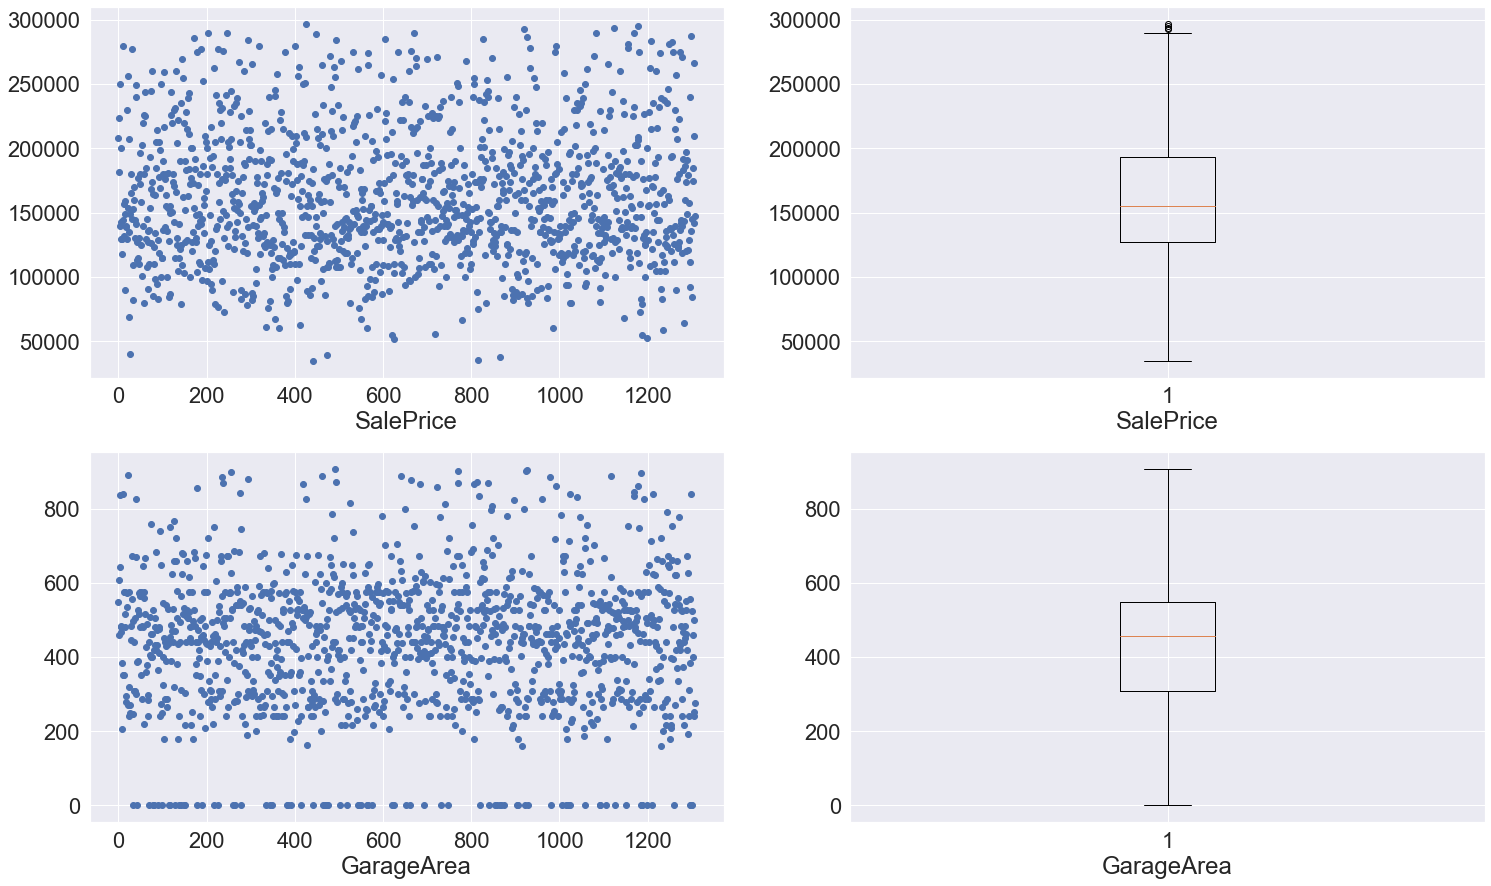

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [104]:
data_train = data_train.drop(data_train[((max_ < data_train['GarageArea'])) & ((data_train['GarageArea'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['GarageArea'].size)),
                       y = data_train['GarageArea'].tolist())
aix[1,0].set_xlabel('GarageArea')
aix[1,1].boxplot(data_train['GarageArea'])
aix[1,1].set_xlabel('GarageArea')
plt.show()
data_train

Очистка TotalBsmtSF

In [121]:
Q1 = q1(data_train['TotalBsmtSF'])
Q3 = q3(data_train['TotalBsmtSF'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('TotalBsmtSF Q1', Q1)
print('TotalBsmtSF Q3', Q3)
print('TotalBsmtSF IQR', IQR)
print('TotalBsmtSF min', min_)
print('TotalBsmtSF max', max_)

TotalBsmtSF Q1 775.5
TotalBsmtSF Q3 1196.5
TotalBsmtSF IQR 421.0
TotalBsmtSF min 144.0
TotalBsmtSF max 1828.0


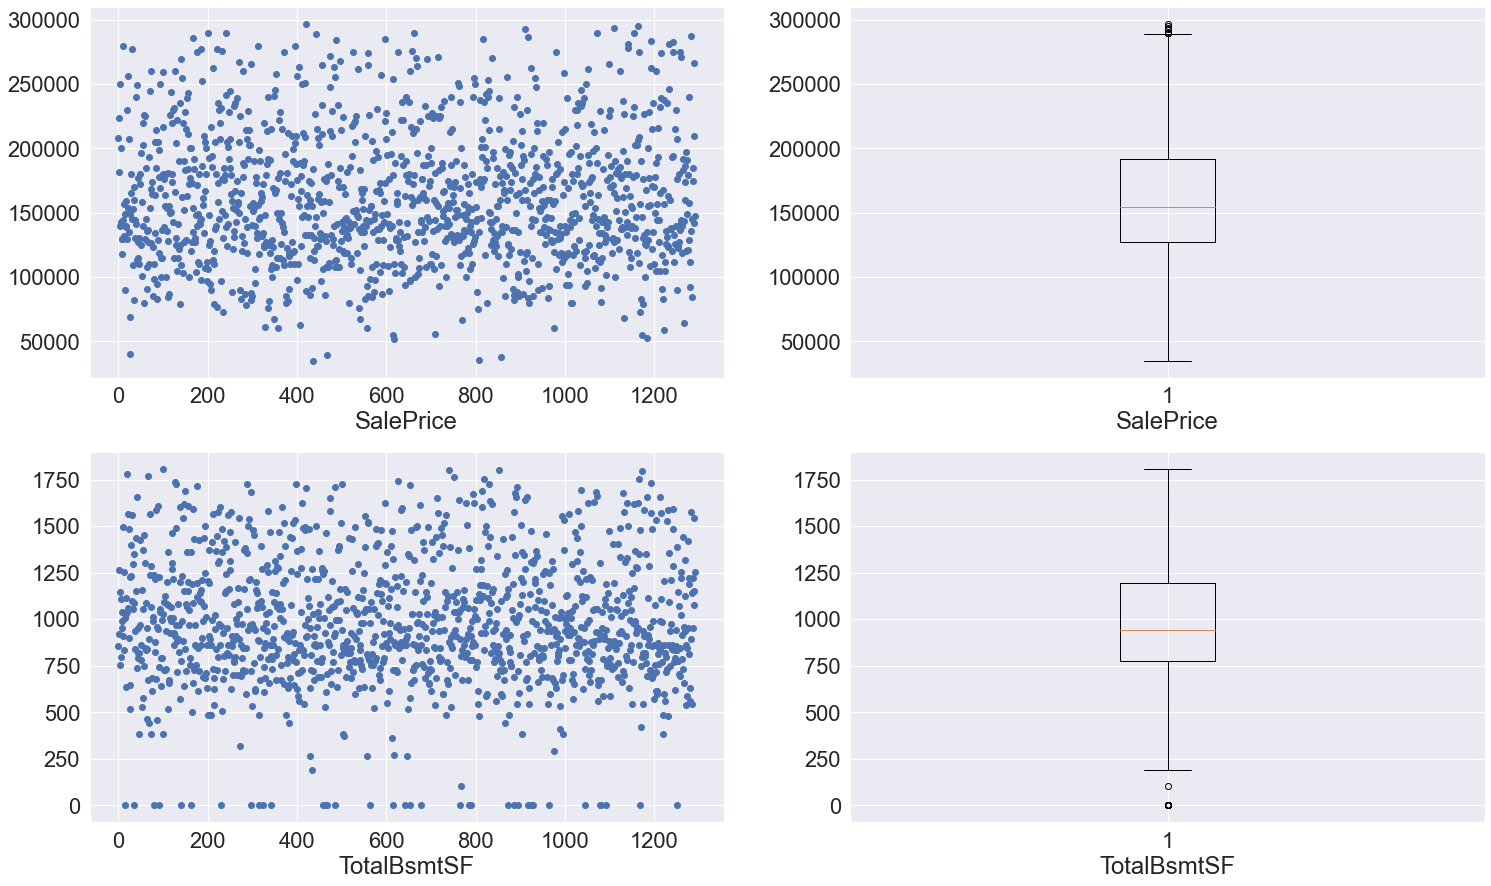

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1455          2000         0.0           0           0  ...               0   
1456          1988       119.0         790         163  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [122]:
data_train = data_train.drop(data_train[((max_ < data_train['TotalBsmtSF'])) & ((data_train['TotalBsmtSF'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['TotalBsmtSF'].size)),
                       y = data_train['TotalBsmtSF'].tolist())
aix[1,0].set_xlabel('TotalBsmtSF')
aix[1,1].boxplot(data_train['TotalBsmtSF'])
aix[1,1].set_xlabel('TotalBsmtSF')
plt.show()
data_train

Очистка 1stFlrSF

In [1300]:
Q1 = q1(data_train['1stFlrSF'])
Q3 = q3(data_train['1stFlrSF'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('1stFlrSF Q1', Q1)
print('1stFlrSF Q3', Q3)
print('1stFlrSF IQR', IQR)
print('1stFlrSF min', min_)
print('1stFlrSF max', max_)

1stFlrSF Q1 864.0
1stFlrSF Q3 1297.0
1stFlrSF IQR 433.0
1stFlrSF min 214.5
1stFlrSF max 1946.5


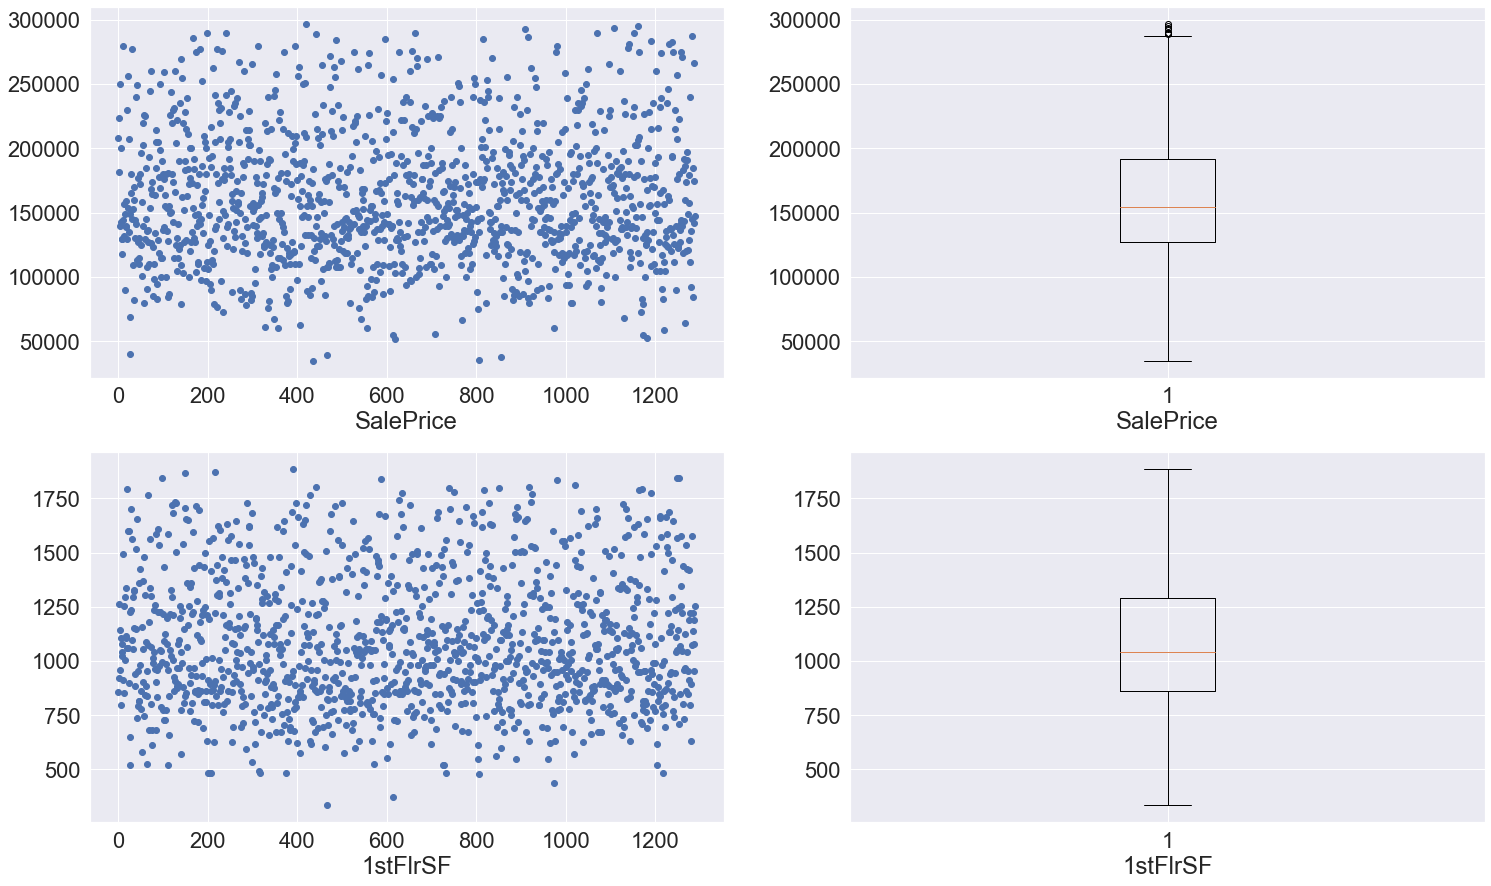

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1454          20         62.0     7500            7            5       2004   
1455          60         62.0     7917            6            5       1999   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1454          2005         0.0         410           0  ...               0   
1455          2000         0.0           0           0  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1454             0             0            1                      0   
1455             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1454                      0                     0                     0   
1455                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [1301]:
data_train = data_train.drop(data_train[((max_ < data_train['1stFlrSF'])) & ((data_train['1stFlrSF'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['1stFlrSF'].size)),
                       y = data_train['1stFlrSF'].tolist())
aix[1,0].set_xlabel('1stFlrSF')
aix[1,1].boxplot(data_train['1stFlrSF'])
aix[1,1].set_xlabel('1stFlrSF')
plt.show()
data_train

Очистка TotRmsAbvGrd

In [1302]:
Q1 = q1(data_train['TotRmsAbvGrd'])
Q3 = q3(data_train['TotRmsAbvGrd'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('TotRmsAbvGrd Q1', Q1)
print('TotRmsAbvGrd Q3', Q3)
print('TotRmsAbvGrd IQR', IQR)
print('TotRmsAbvGrd min', min_)
print('TotRmsAbvGrd max', max_)

TotRmsAbvGrd Q1 5.0
TotRmsAbvGrd Q3 7.0
TotRmsAbvGrd IQR 2.0
TotRmsAbvGrd min 2.0
TotRmsAbvGrd max 10.0


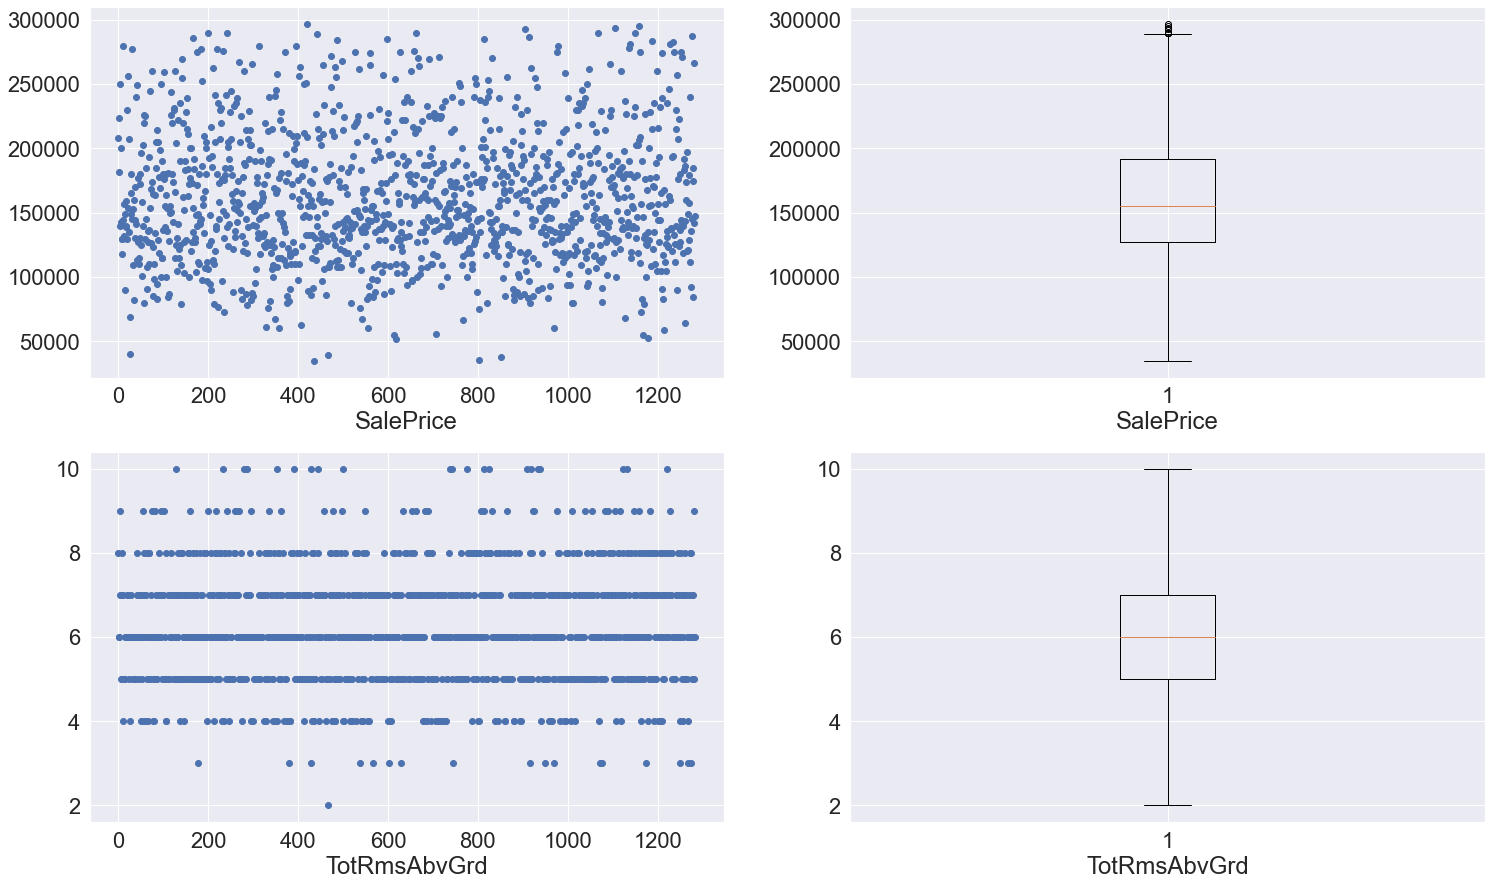

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1454          20         62.0     7500            7            5       2004   
1455          60         62.0     7917            6            5       1999   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0             2003       196.0         706           0  ...               0   
1             1976         0.0         978           0  ...               0   
2             2002       162.0         486           0  ...               0   
3             1970         0.0         216           0  ...               0   
4             2000       350.0         655           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1454          2005         0.0         410           0  ...               0   
1455          2000         0.0           0           0  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1454             0             0            1                      0   
1455             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1454                      0                     0                     0   
1455                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...    

In [1303]:
data_train = data_train.drop(data_train[((max_ < data_train['TotRmsAbvGrd'])) & ((data_train['TotRmsAbvGrd'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['TotRmsAbvGrd'].size)),
                       y = data_train['TotRmsAbvGrd'].tolist())
aix[1,0].set_xlabel('TotRmsAbvGrd')
aix[1,1].boxplot(data_train['TotRmsAbvGrd'])
aix[1,1].set_xlabel('TotRmsAbvGrd')
plt.show()
data_train

Очистка MasVnrArea

In [129]:
Q1 = q1(data_train['MasVnrArea'])
Q3 = q3(data_train['MasVnrArea'])
IQR = Q3-Q1
min_ = 0
max_ = Q3 + 1.5 * IQR
print('MasVnrArea Q1', Q1)
print('MasVnrArea Q3', Q3)
print('MasVnrArea IQR', IQR)
print('MasVnrArea min', min_)
print('MasVnrArea max', max_)

MasVnrArea Q1 0.0
MasVnrArea Q3 0.0
MasVnrArea IQR 0.0
MasVnrArea min 0
MasVnrArea max 0.0


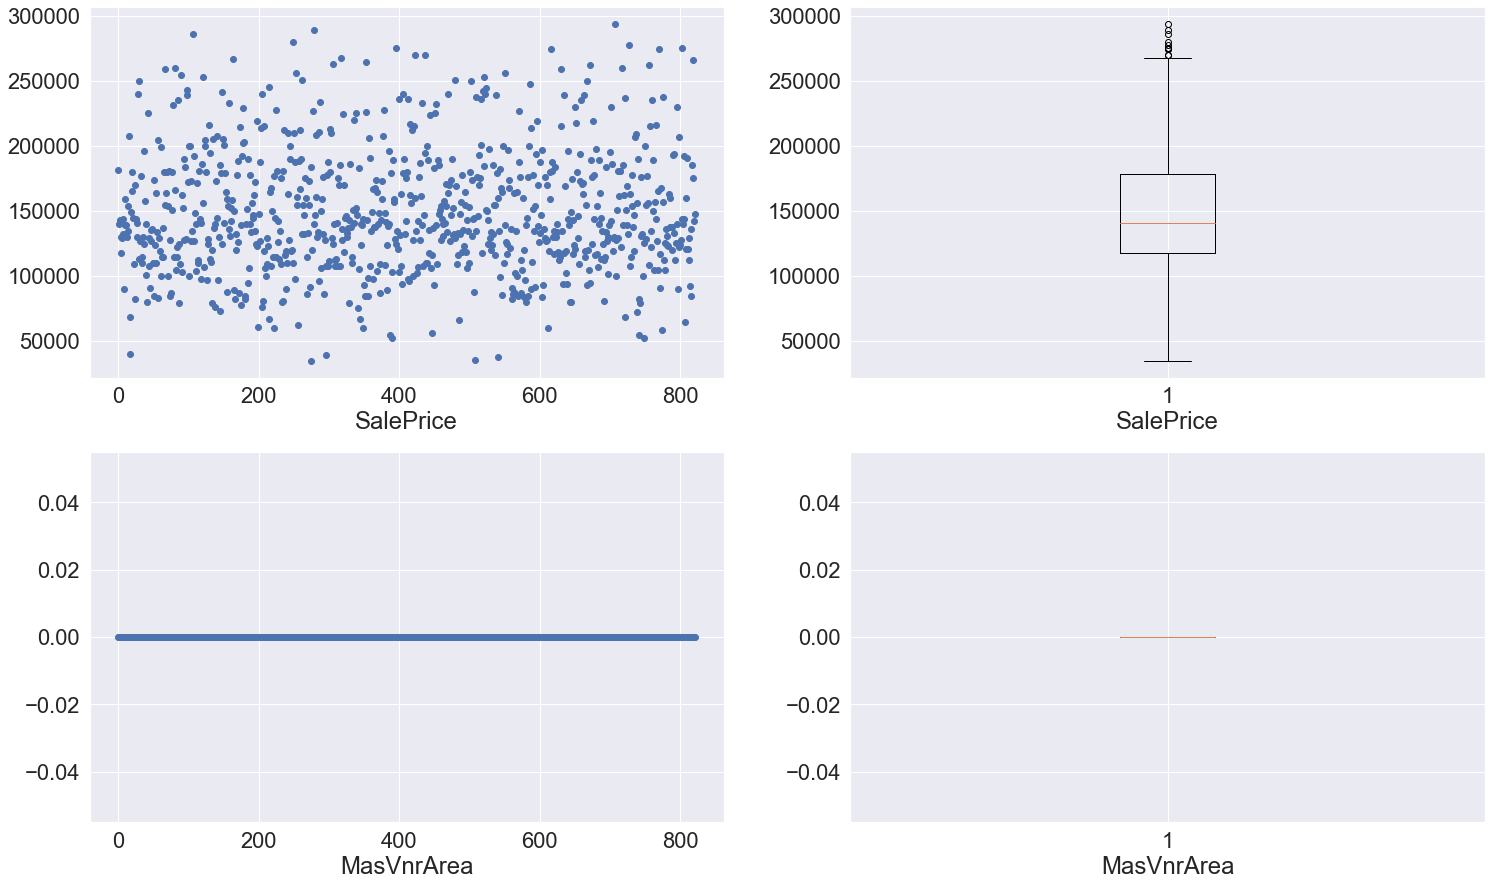

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1             20         80.0     9600            6            8       1976   
3             70         60.0     9550            7            5       1915   
5             50         85.0    14115            5            5       1993   
8             50         51.0     6120            7            5       1931   
9            190         50.0     7420            5            6       1939   
...          ...          ...      ...          ...          ...        ...   
1454          20         62.0     7500            7            5       2004   
1455          60         62.0     7917            6            5       1999   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
1             1976         0.0         978           0  ...               0   
3             1970         0.0         216           0  ...               0   
5             1995         0.0         732           0  ...               0   
8             1950         0.0           0           0  ...               0   
9             1950         0.0         851           0  ...               0   
...            ...         ...         ...         ...  ...             ...   
1454          2005         0.0         410           0  ...               0   
1455          2000         0.0           0           0  ...               0   
1457          2006         0.0         275           0  ...               0   
1458          1996         0.0          49        1029  ...               0   
1459          1965         0.0         830         290  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
1                0             0            1                      0   
3                0             0            1                      1   
5                0             0            1                      0   
8                0             0            1                      1   
9                0             0            1                      0   
...            ...           ...          ...                    ...   
1454             0             0            1                      0   
1455             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
1                         0                     0                     0   
3                         0                     0                     0   
5                         0                     0                     0   
8                         0                     0                     0   
9                         0                     0                     0   
...                     ...                   ...                   ...   
1454                      0                     0                     0   
1455                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
1                        1                      0  
3                        0                      0  
5                        1                      0  
8                        0                      0  
9                        1                      0  
...                    ...    

In [130]:
data_train = data_train.drop(data_train[((max_ < data_train['MasVnrArea'])) & ((data_train['MasVnrArea'] > min_))].index)
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 2, ncols = 2 ,figsize=(25,15))

aix[0,0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[0,0].set_xlabel('SalePrice')
aix[0,1].boxplot(data_train['SalePrice'])
aix[0,1].set_xlabel('SalePrice')



aix[1,0].scatter(x = list(range(data_train['MasVnrArea'].size)),
                       y = data_train['MasVnrArea'].tolist())
aix[1,0].set_xlabel('MasVnrArea')
aix[1,1].boxplot(data_train['MasVnrArea'])
aix[1,1].set_xlabel('MasVnrArea')
plt.show()
data_train

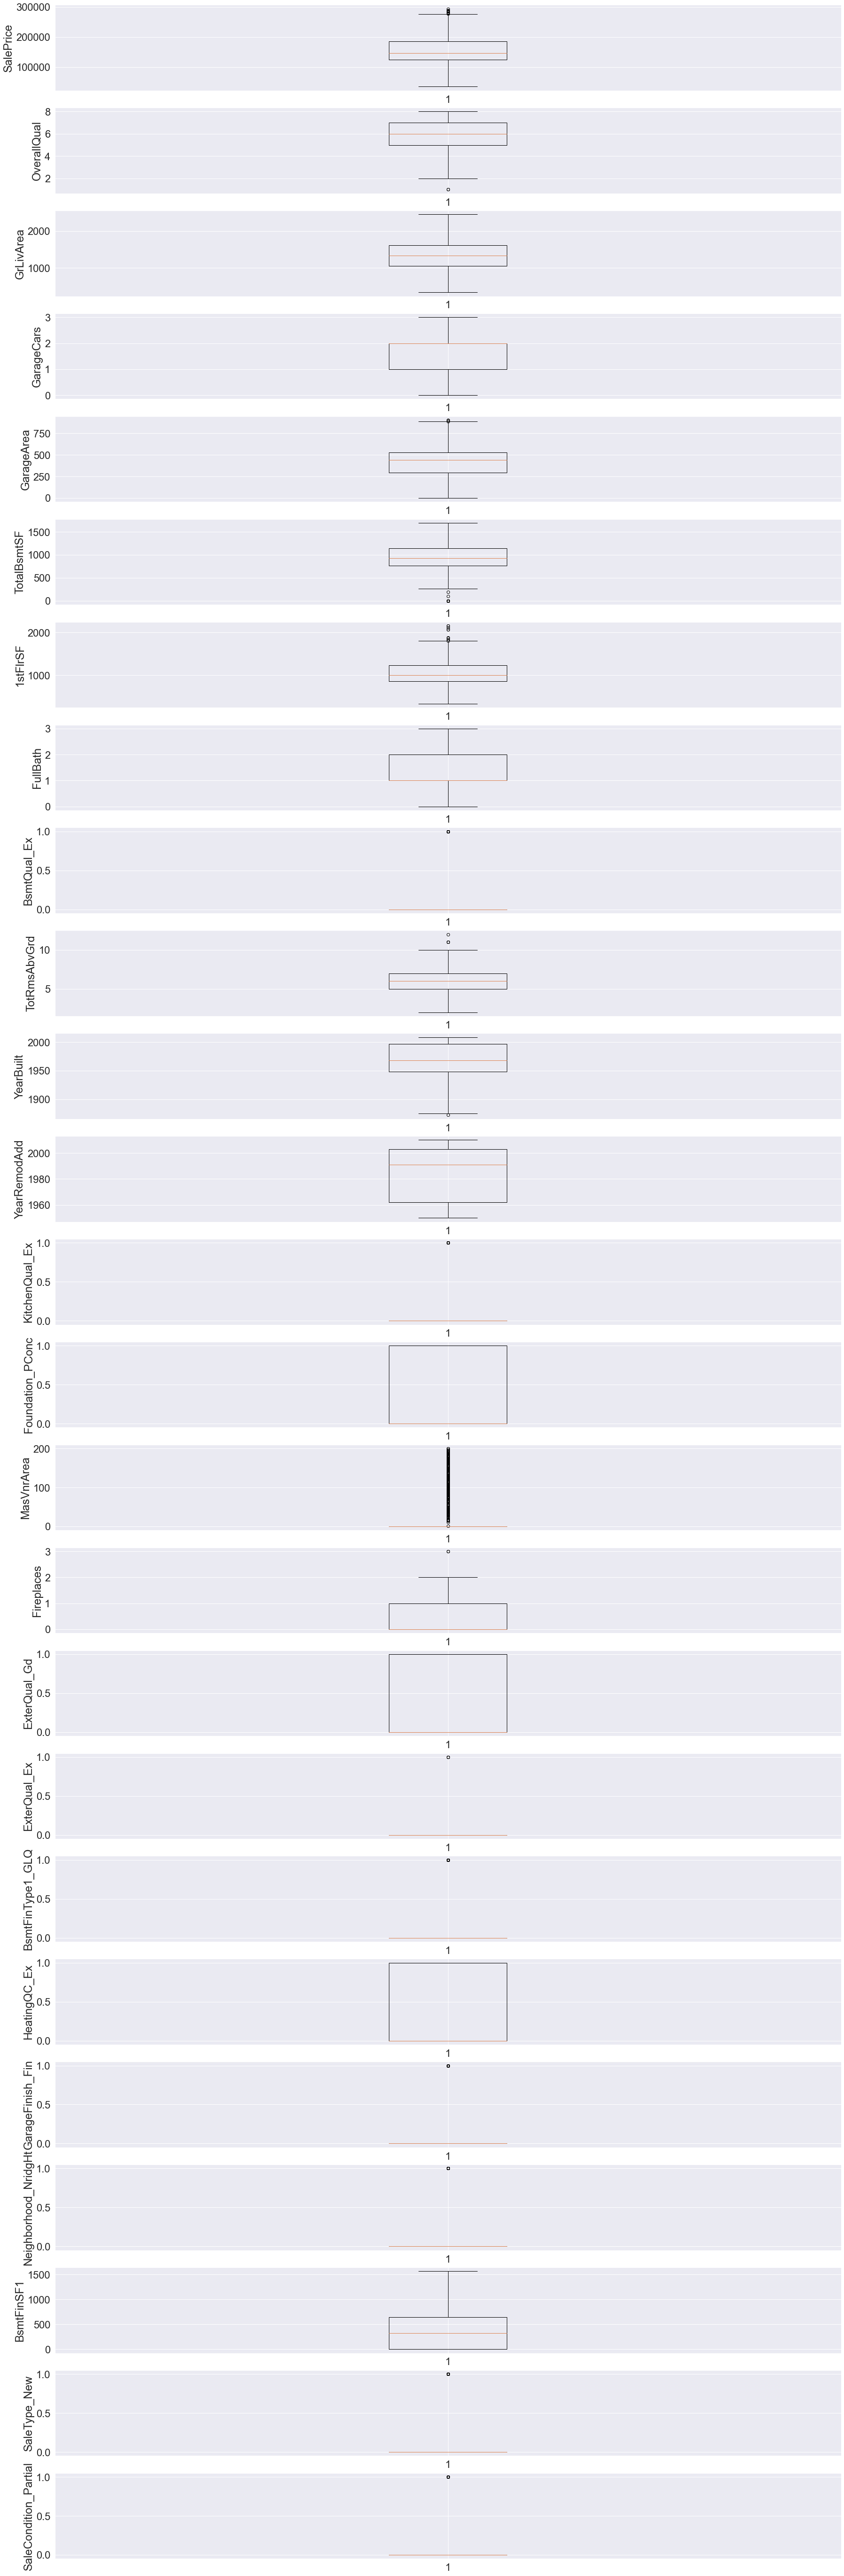

In [1581]:
fig_1, axs_1 = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,100))
for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
    axs_1[ctn].boxplot(data_train[i])
    axs_1[ctn].set_ylabel(i)

plt.show()

# Подготавливаем данные для обучения

In [253]:
len(list(data_train[corrmat.nlargest(k, 'SalePrice').index].columns))

25

In [254]:
data_for_fit = data_train[corrmat.nlargest(k, 'SalePrice').index]

In [255]:
# Отделяем значения для обучения модели
test_size = 0.3
train_size = 0.7
random_state = 42

train, test= train_test_split(data_for_fit, 
                              test_size = test_size, 
                              train_size = train_size,
                              random_state = random_state)   
train_X = train.drop('SalePrice', axis = 1)
train_Y = train['SalePrice']
test_X = test.drop('SalePrice', axis = 1)
test_Y = test['SalePrice']

In [256]:
train_X = tf.convert_to_tensor(train_X)

In [257]:
train_X

<tf.Tensor: shape=(1021, 24), dtype=float64, numpy=
array([[7.000e+00, 1.682e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 1.072e+03, 2.000e+00, ..., 5.470e+02, 0.000e+00,
        0.000e+00],
       [7.000e+00, 1.547e+03, 2.000e+00, ..., 2.400e+01, 0.000e+00,
        0.000e+00],
       ...,
       [4.000e+00, 1.981e+03, 2.000e+00, ..., 6.220e+02, 0.000e+00,
        0.000e+00],
       [5.000e+00, 8.640e+02, 2.000e+00, ..., 1.670e+02, 0.000e+00,
        0.000e+00],
       [7.000e+00, 1.426e+03, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])>

In [258]:
train_Y = tf.convert_to_tensor(train_Y)

In [259]:
test_X = tf.convert_to_tensor(test_X)

In [260]:
test_Y = tf.convert_to_tensor(test_Y)

**Данные для првоерки**

In [261]:
data_for_test = pd.read_csv(r'test.csv')
data_for_test = data_for_test.drop('Id',axis=1)
data_for_test['SalePrice'] = np.zeros(len(data_for_test))

In [262]:
X_check = ConvertCatToNum(data_for_test)[corrmat.nlargest(k, 'SalePrice').index].drop('SalePrice',axis=1)

In [263]:
X_check.isna().sum().sum()

19

In [264]:
na_col = []
for i in X_check.columns:
    if X_check[i].isna().sum()>0:
        for j in X_check[X_check[i].isna() == True].index:
            na_col.append(j)
na_col = list(set(na_col))

In [265]:
X_check = X_check.drop(index= na_col)

In [266]:
X_check.isna().sum().sum()

0

In [267]:
Y_check = pd.read_csv(r'sample_submission.csv')
Y_check = Y_check.drop('Id',axis=1)


In [268]:
Y_check = Y_check.drop(index= na_col)
Y_check

SalePrice
0     169277.052498
1     187758.393989
2     183583.683570
3     179317.477511
4     150730.079977
...             ...
1454  167081.220949
1455  164788.778231
1456  219222.423400
1457  184924.279659
1458  187741.866657

[1442 rows x 1 columns]

In [269]:
Y_check = tf.convert_to_tensor(Y_check['SalePrice'])
X_check = tf.convert_to_tensor(X_check)
print(X_check)
print(Y_check)

tf.Tensor(
[[5.000e+00 8.960e+02 1.000e+00 ... 4.680e+02 0.000e+00 0.000e+00]
 [6.000e+00 1.329e+03 1.000e+00 ... 9.230e+02 0.000e+00 0.000e+00]
 [5.000e+00 1.629e+03 2.000e+00 ... 7.910e+02 0.000e+00 0.000e+00]
 ...
 [5.000e+00 1.224e+03 2.000e+00 ... 1.224e+03 0.000e+00 0.000e+00]
 [5.000e+00 9.700e+02 0.000e+00 ... 3.370e+02 0.000e+00 0.000e+00]
 [7.000e+00 2.000e+03 3.000e+00 ... 7.580e+02 0.000e+00 0.000e+00]], shape=(1442, 24), dtype=float64)
tf.Tensor(
[169277.0524984  187758.39398877 183583.68356955 ... 219222.42340006
 184924.279659   187741.86665748], shape=(1442,), dtype=float64)


## Классификация с использованием классического перцептрона 

In [270]:
# # Parameters 
# batch_size = 20 
# display_step = 1
# adam = tf.keras.optimizers.Adam(learning_rate=0.000001)
# epochs = 300
# activation = 'ReLU'
# loss=tf.keras.losses.MeanAbsolutePercentageError()
# # loss = tf.losses.MeanAbsoluteError()

# # Создаем слой нормализации входных данных
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(train_X))
# print('Значения для нормализации: ', normalizer.mean.numpy())
# print('-------------------------------------------------------')

# input_regr_model = tf.keras.layers.Input(shape=(k,),
#                              name="Input_RegModel")
# # x = normalizer()(input_regr_model)
# X_shortcut = x
# x = tf.keras.layers.Dense(32, activation=activation)(input_regr_model)
# x = tf.keras.layers.Dense(64, activation=activation)(x)
# x = tf.keras.layers.Add()([x, X_shortcut])# SKIP Connection
# x = tf.keras.layers.Dense(128, activation=activation)(x)

# RegModel = tf.keras.Model(input_regr_model, x, name="encoder")
# plot_model(RegModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [273]:
# Parameters 
batch_size = 20 
display_step = 1
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
epochs = 3000
activation = 'elu'
loss=tf.keras.losses.MeanAbsolutePercentageError()
# loss = tf.keras.activations.selu
dropout = 0.45
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
# Создаем слой нормализации входных данных
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_X))
print('Значения для нормализации: ', normalizer.mean.numpy())


model = tf.keras.models.Sequential()
model.add(normalizer)
model.add(tf.keras.Input(shape=(k,)))
model.add(tf.keras.layers.Dense(32, activation=activation))

model.add(tf.keras.layers.Dense(64, activation=activation))
model.add(tf.keras.layers.Dense(128, activation=activation))
model.add(tf.keras.layers.Dense(256, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(512, activation=activation))
model.add(tf.keras.layers.Dense(1024, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(2048, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(1024, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(512, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(256, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(128, activation=activation))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(64, activation=activation))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.summary()
model.compile(optimizer = adam, loss=loss)
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Значения для нормализации:  [[6.1273270e+00 1.5292173e+03 1.7825661e+00 4.7694122e+02 1.0594612e+03
  1.1693604e+03 1.5817827e+00 8.4231153e-02 6.5445623e+00 1.9709597e+03
  1.9847355e+03 6.3663065e-02 4.4564158e-01 1.0492753e+02 6.1312431e-01
  3.3202744e-01 3.4280114e-02 2.8991181e-01 5.0734568e-01 2.4583742e-01
  4.8971586e-02 4.4661313e+02 8.2272291e-02 8.3251722e-02]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 24)               49        
 ion)                                                            
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 dense_25 (Dense)            (None, 32)                800       
                                                                 
 dense_2

In [274]:
model_fit = model.fit(x = train_X,
                      y = train_Y,
                      epochs=epochs,
                      batch_size = batch_size,
                      validation_data = (test_X, test_Y),
                      callbacks=[tb_callback])

Epoch 1/3000
52/52 [==============================] - 2s 22ms/step - loss: 99.9995 - val_loss: 99.9992
Epoch 2/3000
52/52 [==============================] - 0s 9ms/step - loss: 99.9990 - val_loss: 99.9982
Epoch 3/3000
52/52 [==============================] - 0s 9ms/step - loss: 99.9983 - val_loss: 99.9968
Epoch 4/3000
52/52 [==============================] - 0s 9ms/step - loss: 99.9967 - val_loss: 99.9943
Epoch 5/3000
52/52 [==============================] - 0s 9ms/step - loss: 99.9939 - val_loss: 99.9894
Epoch 6/3000
52/52 [==============================] - 0s 9ms/step - loss: 99.9877 - val_loss: 99.9772
Epoch 7/3000
52/52 [==============================] - 0s 10ms/step - loss: 99.9692 - val_loss: 99.9392
Epoch 8/3000
52/52 [==============================] - 1s 10ms/step - loss: 99.8962 - val_loss: 99.7765
Epoch 9/3000
52/52 [==============================] - 1s 10ms/step - loss: 99.5246 - val_loss: 98.9045
Epoch 10/3000
52/52 [==============================] - 1s 10ms/step - loss: 97

Epoch 80/3000
52/52 [==============================] - 0s 9ms/step - loss: 22.2380 - val_loss: 17.1695
Epoch 81/3000
52/52 [==============================] - 0s 9ms/step - loss: 21.7819 - val_loss: 17.0999
Epoch 82/3000
52/52 [==============================] - 0s 9ms/step - loss: 22.2938 - val_loss: 17.0384
Epoch 83/3000
52/52 [==============================] - 0s 9ms/step - loss: 21.7879 - val_loss: 16.9277
Epoch 84/3000
52/52 [==============================] - 0s 9ms/step - loss: 22.1323 - val_loss: 16.7919
Epoch 85/3000
52/52 [==============================] - 0s 9ms/step - loss: 22.0788 - val_loss: 16.9236
Epoch 86/3000
52/52 [==============================] - 0s 9ms/step - loss: 22.7934 - val_loss: 17.4221
Epoch 87/3000
52/52 [==============================] - 0s 9ms/step - loss: 22.2334 - val_loss: 16.6791
Epoch 88/3000
52/52 [==============================] - 0s 10ms/step - loss: 20.8372 - val_loss: 16.5786
Epoch 89/3000
52/52 [==============================] - 1s 10ms/step - lo

52/52 [==============================] - 0s 9ms/step - loss: 19.9708 - val_loss: 14.8756
Epoch 159/3000
52/52 [==============================] - 0s 9ms/step - loss: 18.8349 - val_loss: 14.6127
Epoch 160/3000
52/52 [==============================] - 0s 9ms/step - loss: 20.1963 - val_loss: 14.8581
Epoch 161/3000
52/52 [==============================] - 0s 9ms/step - loss: 19.0006 - val_loss: 14.8129
Epoch 162/3000
52/52 [==============================] - 0s 9ms/step - loss: 18.8370 - val_loss: 14.5040
Epoch 163/3000
52/52 [==============================] - 0s 9ms/step - loss: 19.0750 - val_loss: 14.4749
Epoch 164/3000
52/52 [==============================] - 0s 9ms/step - loss: 19.7289 - val_loss: 14.6031
Epoch 165/3000
52/52 [==============================] - 0s 9ms/step - loss: 19.8799 - val_loss: 14.8067
Epoch 166/3000
52/52 [==============================] - 1s 10ms/step - loss: 19.0096 - val_loss: 14.4031
Epoch 167/3000
52/52 [==============================] - 0s 10ms/step - loss: 1

KeyboardInterrupt: 

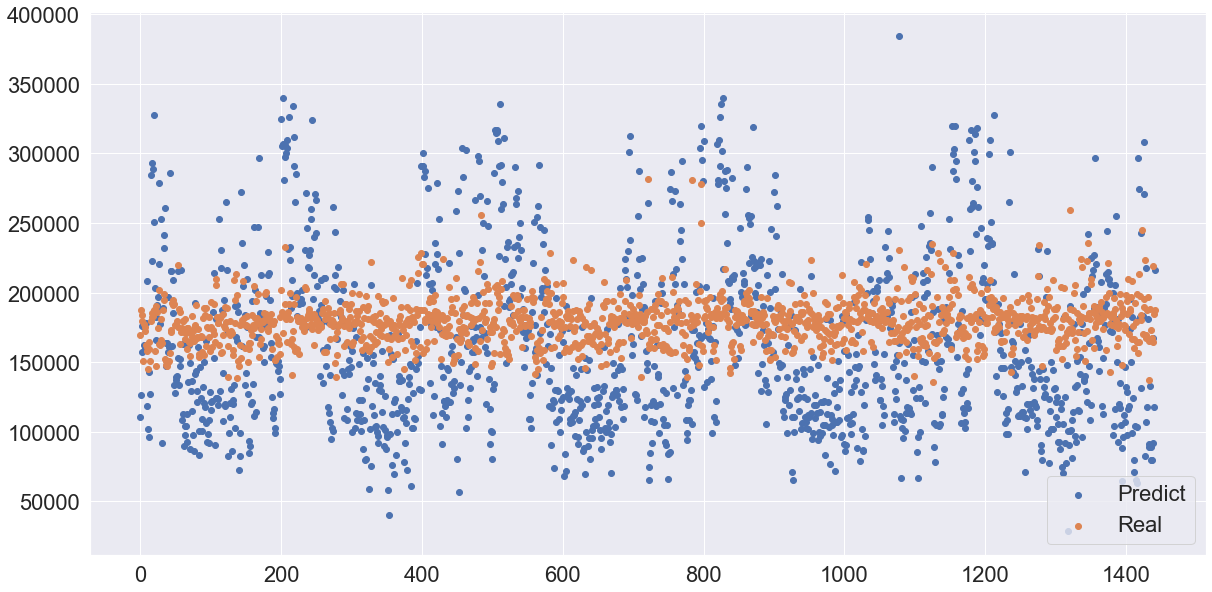

Mean squared error:  3624276748.9579253
Mean absolute error:  51126.27978171459
Coefficient of determination:  -12.215077575635833
Mean absolute percentage error:  28.78868763662499 %
Mean squared log error:  0.145732738311402
Root Mean Squared Log Error:  0.38174957539125304


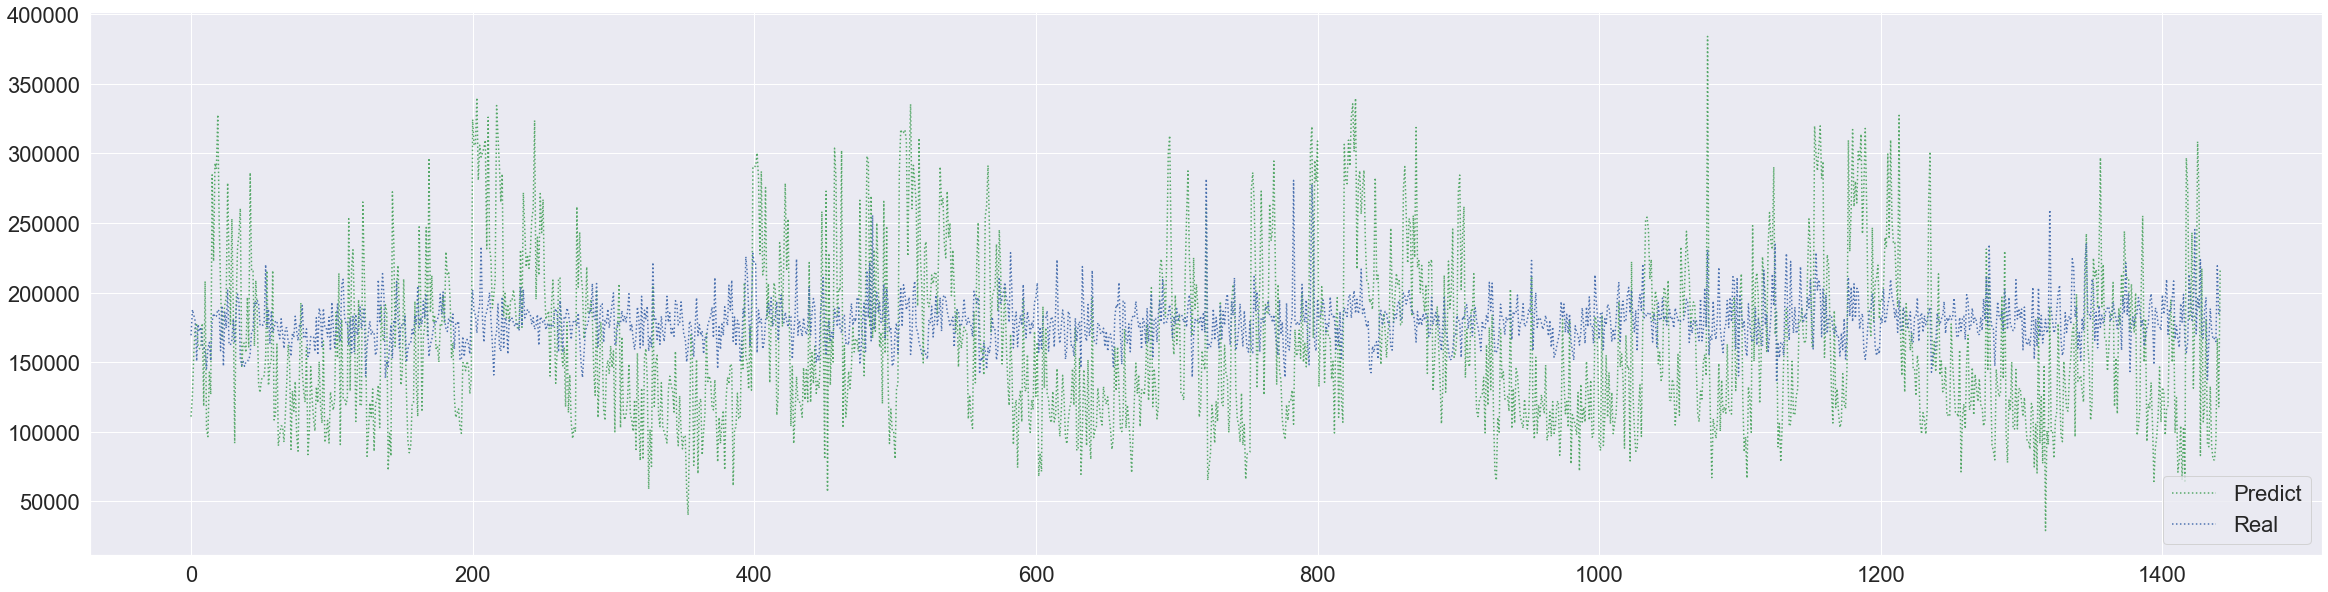

In [275]:
def PrintScatterAndCalculateLoos(test_X, test_Y):
    temp = test_X
    plt.figure(figsize=(20,10))
    plt.scatter(x = list(range(len(temp))), y = temp, label='Predict')
    plt.scatter(x = list(range(len(test_Y.numpy().tolist()))), y = test_Y.numpy().tolist(), label = 'Real')
    plt.legend(loc='lower right')
    plt.show()

    mse = mean_squared_error(test_Y.numpy().tolist(), temp)
    print('Mean squared error: ', mse)
    mae = mean_absolute_error(test_Y.numpy().tolist(), temp)
    print('Mean absolute error: ', mae)
    r2 = r2_score(test_Y.numpy().tolist(), temp)
    print('Coefficient of determination: ', r2)
    mape = mean_absolute_percentage_error(test_Y.numpy().tolist(), temp)
    print('Mean absolute percentage error: ', mape*100,'%')
    msle = mean_squared_log_error(test_Y.numpy().tolist(), temp)
    print('Mean squared log error: ', msle)
    rmsle = np.sqrt(msle)
    print('Root Mean Squared Log Error: ', rmsle)
    
    plt.figure(figsize=(40,10))
    plt.plot(temp,'g:', label = 'Predict')
    plt.plot(test_Y.numpy().tolist(), 'b:', label = 'Real')
    plt.legend(loc='lower right')
    plt.show()
    
    
temp = []
for i in model(X_check).numpy().tolist():
    temp.append(i[0])
    
PrintScatterAndCalculateLoos(temp, Y_check)

In [ ]:
# test_Y.numpy().tolist()

## Предсказание цены с использованием леса рандомизированных деревьев

In [276]:
clfRFC = RandomForestClassifier(n_estimators = 500, 
                                criterion = 'gini', 
                                max_depth = 150, 
                                min_samples_split = 2, 
                                random_state=0)

In [277]:
clfRFC.fit(train_X, train_Y)

RandomForestClassifier(max_depth=150, n_estimators=500, random_state=0)

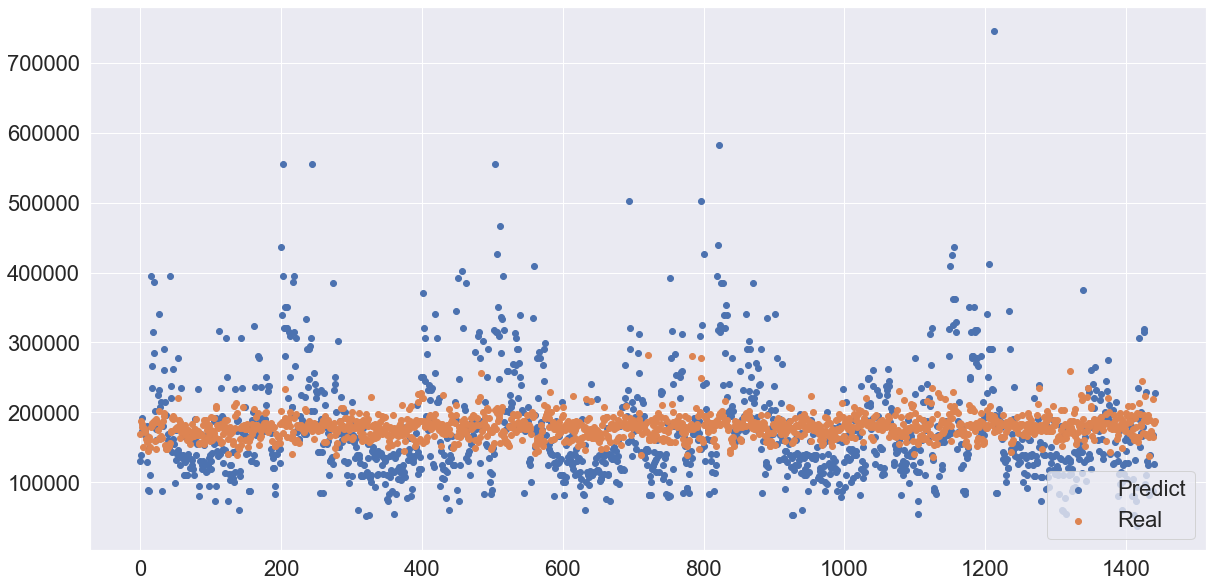

Mean squared error:  5322442553.983399
Mean absolute error:  55025.392456556205
Coefficient of determination:  -18.407042043072327
Mean absolute percentage error:  30.668772852318966 %
Mean squared log error:  0.152096312263662
Root Mean Squared Log Error:  0.3899952721042423


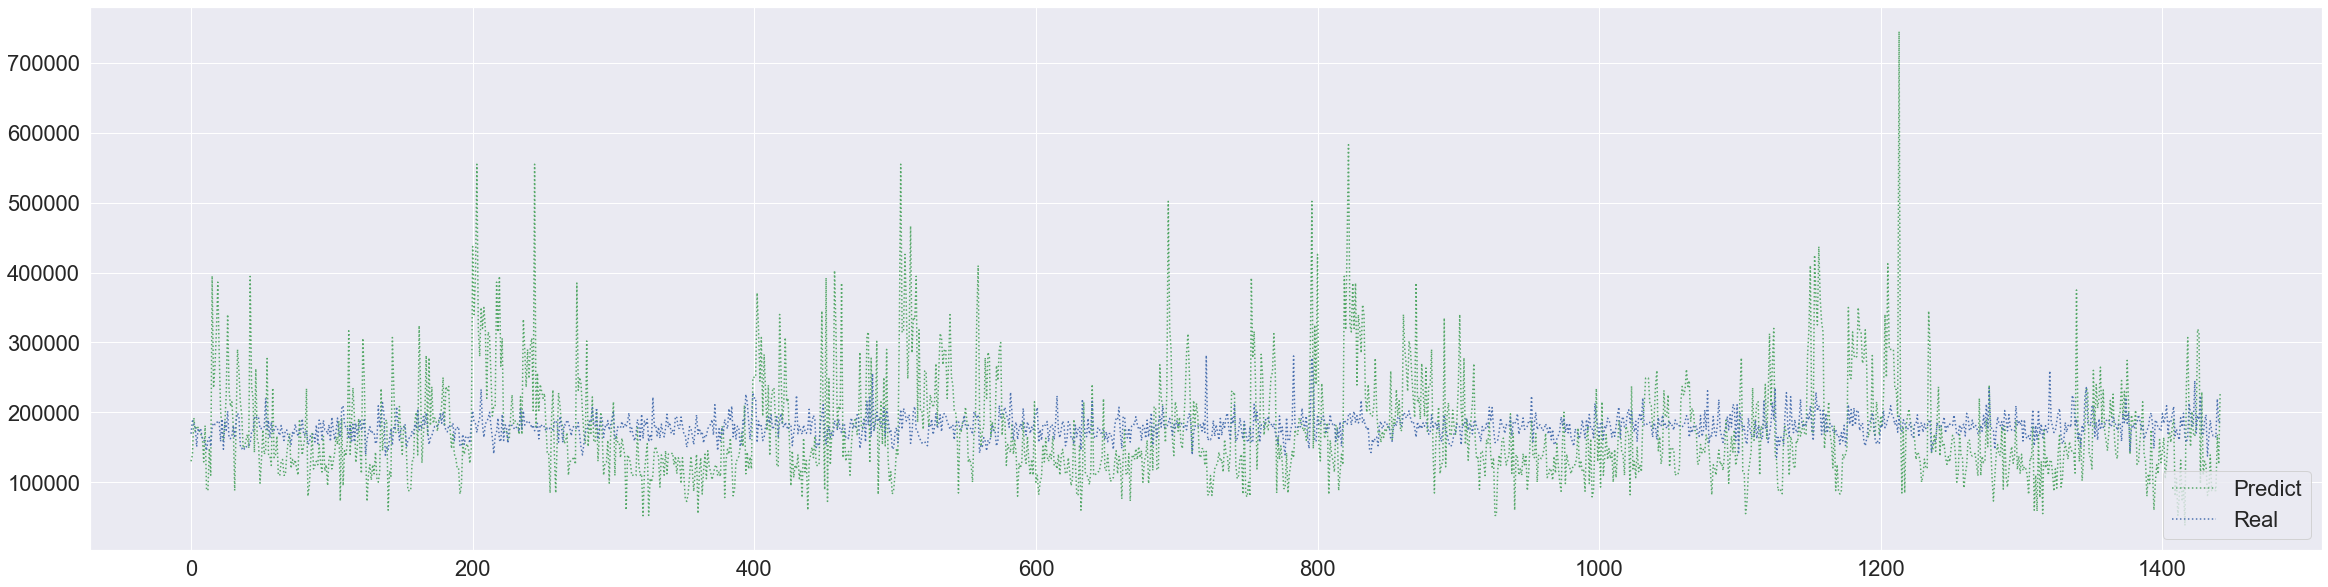

In [278]:
PrintScatterAndCalculateLoos(clfRFC.predict(X_check), Y_check)

## Предсказание цены с использованием определенных рандомизированных деревьев

In [279]:
clfDTC = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

In [280]:
clfDTC.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=0)

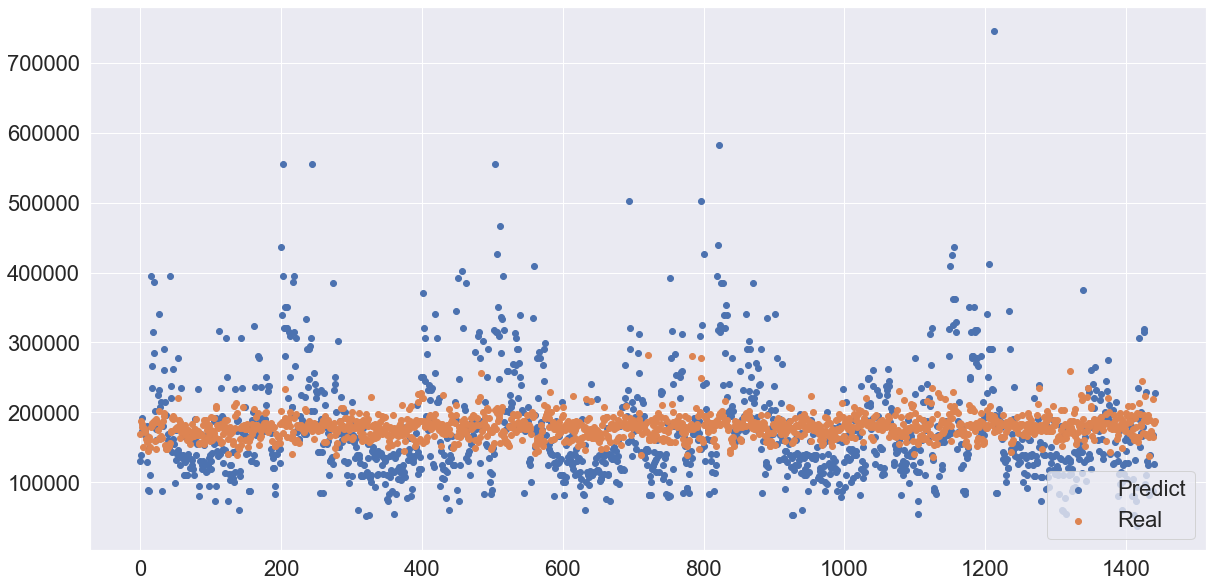

Mean squared error:  5322442553.983399
Mean absolute error:  55025.392456556205
Coefficient of determination:  -18.407042043072327
Mean absolute percentage error:  30.668772852318966 %
Mean squared log error:  0.152096312263662
Root Mean Squared Log Error:  0.3899952721042423


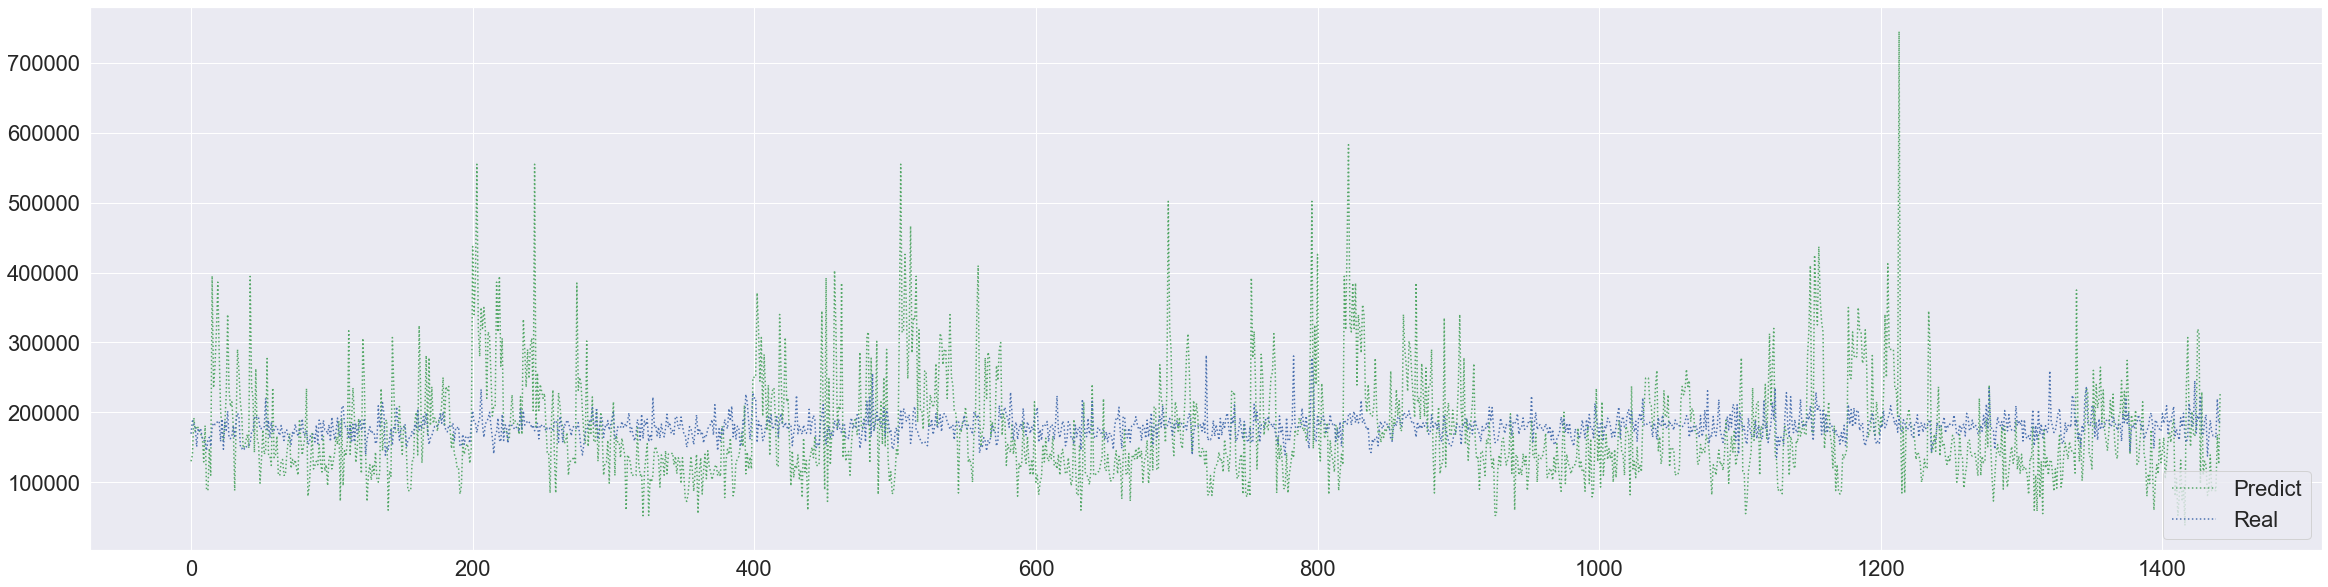

In [281]:
PrintScatterAndCalculateLoos(clfRFC.predict(X_check), Y_check)

**Градиентный бустинг**

In [285]:
model_lgb = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42, force_row_wise=True)

In [286]:
model_lgb.fit(train_X, train_Y)
lgb_train_pred = model_lgb.predict(X_check)

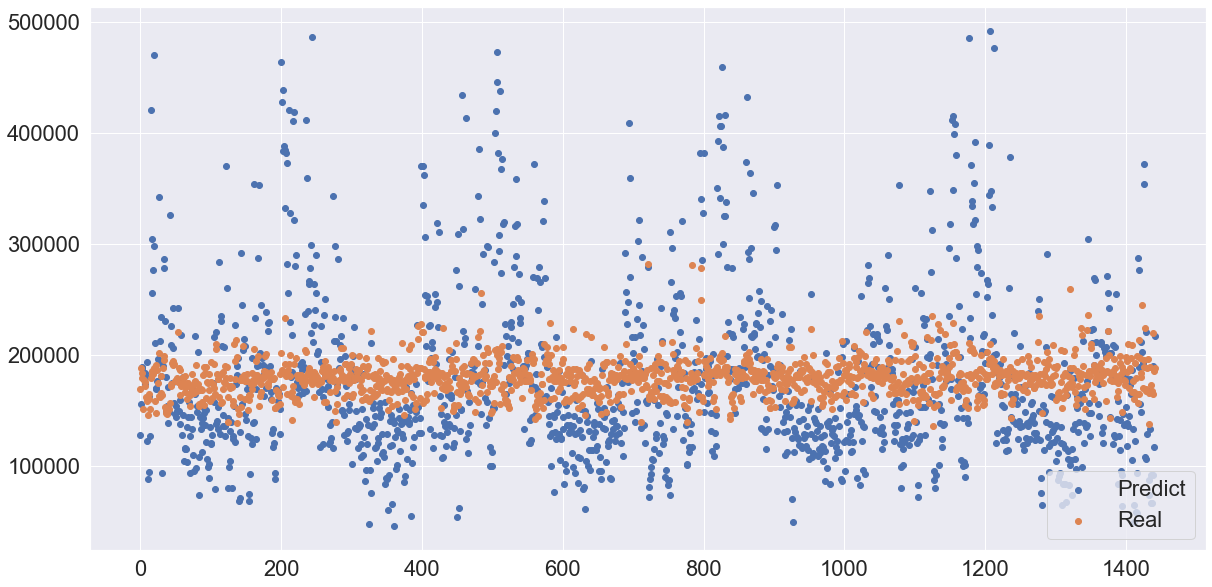

Mean squared error:  5270891586.42658
Mean absolute error:  55029.847154976196
Coefficient of determination:  -18.219073495814357
Mean absolute percentage error:  30.670481807872147 %
Mean squared log error:  0.14508832148298878
Root Mean Squared Log Error:  0.38090460942733256


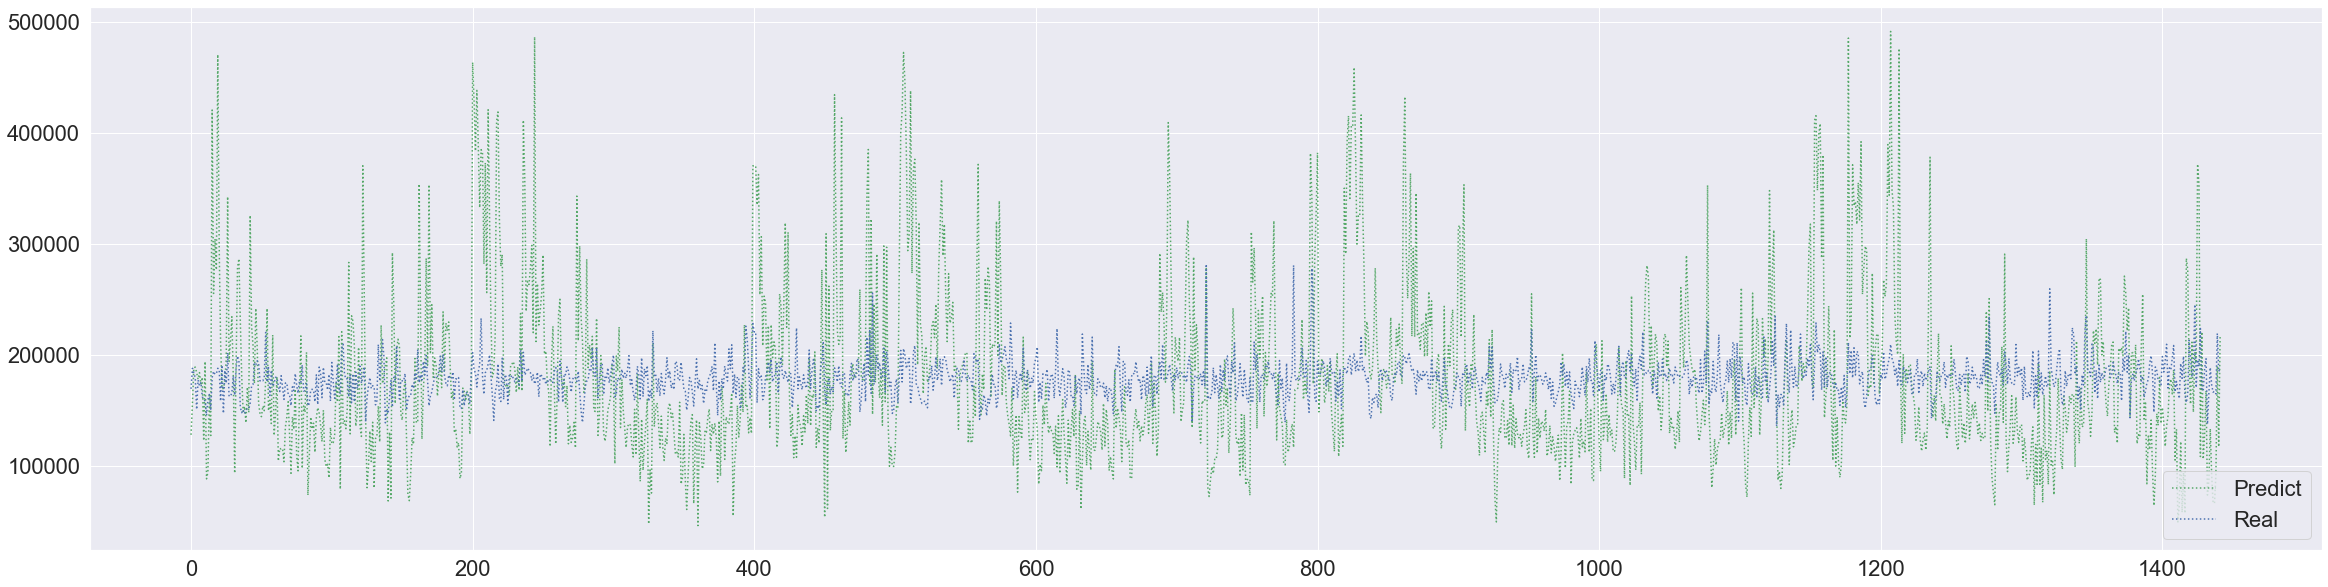

In [287]:
PrintScatterAndCalculateLoos(lgb_train_pred, Y_check)

In [1610]:
np.sqrt(mean_squared_error(lgb_train_pred, Y_check))

55409.41383921818

In [288]:
xgboost = XGBRegressor(learning_rate=0.001,
                       n_estimators=6000,
                       max_depth=15,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

[15:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


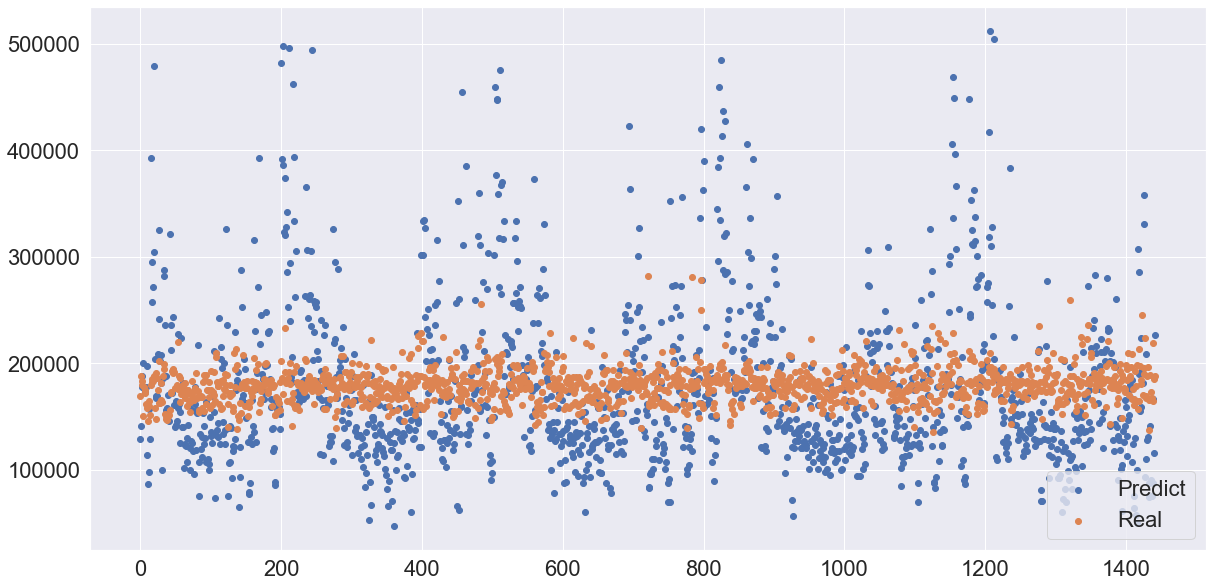

Mean squared error:  5187201093.630759
Mean absolute error:  54601.02102840097
Coefficient of determination:  -17.913915686064325
Mean absolute percentage error:  30.4355393479598 %
Mean squared log error:  0.14107678773861743
Root Mean Squared Log Error:  0.37560190060570436


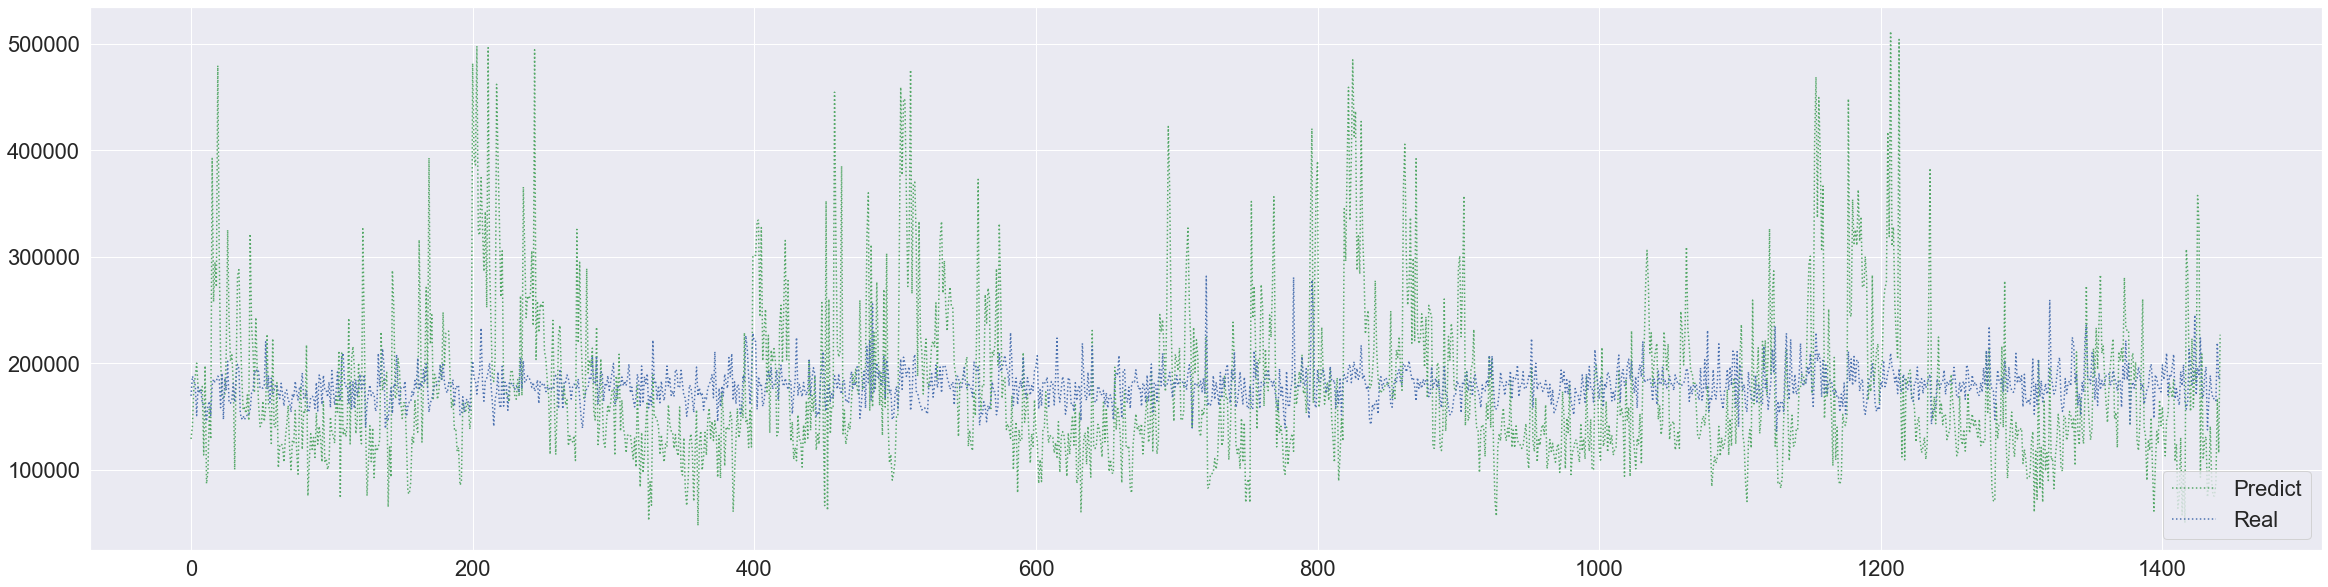

In [289]:
xgboost.fit(train_X, train_Y)
PrintScatterAndCalculateLoos(xgboost.predict(X_check), Y_check)

In [293]:
modelCatBoostRegressor = CatBoostRegressor(iterations=1000,
                           task_type="GPU",
                           devices='0:1')

In [296]:
modelCatBoostRegressor.fit(train_X.numpy(), train_Y.numpy())

Learning rate set to 0.040504
0:	learn: 75424.8866279	total: 14.3ms	remaining: 14.3s
1:	learn: 73298.7955383	total: 26.5ms	remaining: 13.2s
2:	learn: 71300.0110777	total: 37.6ms	remaining: 12.5s
3:	learn: 69379.0730496	total: 48.9ms	remaining: 12.2s
4:	learn: 67643.1247033	total: 59.3ms	remaining: 11.8s
5:	learn: 65921.8728146	total: 70.5ms	remaining: 11.7s
6:	learn: 64299.6803978	total: 81.7ms	remaining: 11.6s
7:	learn: 62695.0868748	total: 92.9ms	remaining: 11.5s
8:	learn: 61186.0074173	total: 104ms	remaining: 11.5s
9:	learn: 59753.9306123	total: 115ms	remaining: 11.4s
10:	learn: 58360.5544678	total: 126ms	remaining: 11.4s
11:	learn: 57085.1839452	total: 137ms	remaining: 11.3s
12:	learn: 55824.7989884	total: 148ms	remaining: 11.2s
13:	learn: 54600.9861328	total: 160ms	remaining: 11.2s
14:	learn: 53397.9667733	total: 171ms	remaining: 11.2s
15:	learn: 52344.7930306	total: 182ms	remaining: 11.2s
16:	learn: 51243.4839832	total: 193ms	remaining: 11.2s
17:	learn: 50245.8040503	total: 204ms

164:	learn: 23527.7903081	total: 1.78s	remaining: 9s
165:	learn: 23439.8179974	total: 1.79s	remaining: 8.99s
166:	learn: 23439.1320134	total: 1.8s	remaining: 8.96s
167:	learn: 23366.6290139	total: 1.81s	remaining: 8.96s
168:	learn: 23365.9917020	total: 1.82s	remaining: 8.93s
169:	learn: 23363.4340384	total: 1.82s	remaining: 8.9s
170:	learn: 23288.8061134	total: 1.83s	remaining: 8.89s
171:	learn: 23213.9548669	total: 1.84s	remaining: 8.88s
172:	learn: 23172.3531605	total: 1.86s	remaining: 8.88s
173:	learn: 23171.6163216	total: 1.87s	remaining: 8.86s
174:	learn: 23137.5625083	total: 1.88s	remaining: 8.85s
175:	learn: 23061.7347042	total: 1.89s	remaining: 8.85s
176:	learn: 22992.9817774	total: 1.9s	remaining: 8.84s
177:	learn: 22992.2426797	total: 1.91s	remaining: 8.82s
178:	learn: 22952.3855522	total: 1.92s	remaining: 8.82s
179:	learn: 22951.9185196	total: 1.93s	remaining: 8.8s
180:	learn: 22907.8649577	total: 1.94s	remaining: 8.8s
181:	learn: 22871.7936120	total: 1.95s	remaining: 8.78s


320:	learn: 20347.8628533	total: 3.54s	remaining: 7.49s
321:	learn: 20346.2098096	total: 3.55s	remaining: 7.48s
322:	learn: 20332.1243106	total: 3.56s	remaining: 7.47s
323:	learn: 20331.8101889	total: 3.58s	remaining: 7.46s
324:	learn: 20331.5355258	total: 3.58s	remaining: 7.45s
325:	learn: 20329.5125335	total: 3.6s	remaining: 7.44s
326:	learn: 20328.0000910	total: 3.61s	remaining: 7.43s
327:	learn: 20327.7230081	total: 3.62s	remaining: 7.42s
328:	learn: 20327.5548620	total: 3.63s	remaining: 7.41s
329:	learn: 20312.2911889	total: 3.64s	remaining: 7.4s
330:	learn: 20305.9440075	total: 3.66s	remaining: 7.39s
331:	learn: 20300.8785876	total: 3.67s	remaining: 7.38s
332:	learn: 20278.7748053	total: 3.68s	remaining: 7.38s
333:	learn: 20264.2441180	total: 3.69s	remaining: 7.37s
334:	learn: 20250.4162022	total: 3.71s	remaining: 7.36s
335:	learn: 20238.8664287	total: 3.72s	remaining: 7.35s
336:	learn: 20224.4784530	total: 3.73s	remaining: 7.34s
337:	learn: 20224.3499145	total: 3.74s	remaining: 

478:	learn: 19429.2660289	total: 5.33s	remaining: 5.8s
479:	learn: 19429.1900441	total: 5.34s	remaining: 5.79s
480:	learn: 19425.3730795	total: 5.35s	remaining: 5.78s
481:	learn: 19423.5688257	total: 5.37s	remaining: 5.76s
482:	learn: 19419.8846204	total: 5.38s	remaining: 5.75s
483:	learn: 19419.8160358	total: 5.39s	remaining: 5.75s
484:	learn: 19419.1896739	total: 5.4s	remaining: 5.73s
485:	learn: 19405.1623048	total: 5.41s	remaining: 5.72s
486:	learn: 19401.6648368	total: 5.42s	remaining: 5.71s
487:	learn: 19400.4539325	total: 5.43s	remaining: 5.7s
488:	learn: 19400.4076123	total: 5.45s	remaining: 5.69s
489:	learn: 19400.0750958	total: 5.46s	remaining: 5.68s
490:	learn: 19400.0205030	total: 5.47s	remaining: 5.67s
491:	learn: 19399.9816263	total: 5.48s	remaining: 5.66s
492:	learn: 19391.4301497	total: 5.49s	remaining: 5.65s
493:	learn: 19382.8161197	total: 5.5s	remaining: 5.63s
494:	learn: 19379.4909923	total: 5.51s	remaining: 5.62s
495:	learn: 19376.2804115	total: 5.52s	remaining: 5.

642:	learn: 19046.1117542	total: 7.06s	remaining: 3.92s
643:	learn: 19045.7738947	total: 7.07s	remaining: 3.91s
644:	learn: 19038.2728819	total: 7.08s	remaining: 3.9s
645:	learn: 19038.2147230	total: 7.09s	remaining: 3.89s
646:	learn: 19038.1017762	total: 7.1s	remaining: 3.88s
647:	learn: 19037.7831613	total: 7.11s	remaining: 3.86s
648:	learn: 19037.6457676	total: 7.12s	remaining: 3.85s
649:	learn: 19037.5505186	total: 7.13s	remaining: 3.84s
650:	learn: 19037.4240811	total: 7.14s	remaining: 3.83s
651:	learn: 19034.5528813	total: 7.15s	remaining: 3.82s
652:	learn: 19034.2485391	total: 7.16s	remaining: 3.81s
653:	learn: 19033.7165609	total: 7.17s	remaining: 3.79s
654:	learn: 19032.1036738	total: 7.18s	remaining: 3.78s
655:	learn: 19032.0109265	total: 7.19s	remaining: 3.77s
656:	learn: 19031.4940630	total: 7.21s	remaining: 3.76s
657:	learn: 19031.0083839	total: 7.22s	remaining: 3.75s
658:	learn: 19029.9771181	total: 7.23s	remaining: 3.74s
659:	learn: 19028.9238707	total: 7.24s	remaining: 

806:	learn: 18782.3548561	total: 8.8s	remaining: 2.1s
807:	learn: 18781.5577153	total: 8.81s	remaining: 2.09s
808:	learn: 18780.3666402	total: 8.83s	remaining: 2.08s
809:	learn: 18780.2042927	total: 8.84s	remaining: 2.07s
810:	learn: 18779.7497123	total: 8.85s	remaining: 2.06s
811:	learn: 18779.5873594	total: 8.86s	remaining: 2.05s
812:	learn: 18779.3976612	total: 8.87s	remaining: 2.04s
813:	learn: 18778.0022093	total: 8.88s	remaining: 2.03s
814:	learn: 18777.8389868	total: 8.89s	remaining: 2.02s
815:	learn: 18777.4193873	total: 8.9s	remaining: 2.01s
816:	learn: 18777.2621419	total: 8.91s	remaining: 2s
817:	learn: 18776.1716431	total: 8.92s	remaining: 1.99s
818:	learn: 18776.0169512	total: 8.93s	remaining: 1.97s
819:	learn: 18767.0024525	total: 8.94s	remaining: 1.96s
820:	learn: 18766.8579460	total: 8.95s	remaining: 1.95s
821:	learn: 18765.8968205	total: 8.96s	remaining: 1.94s
822:	learn: 18765.7582913	total: 8.97s	remaining: 1.93s
823:	learn: 18764.5687789	total: 8.99s	remaining: 1.92

969:	learn: 18587.6764567	total: 10.6s	remaining: 327ms
970:	learn: 18587.0470897	total: 10.6s	remaining: 316ms
971:	learn: 18587.0393196	total: 10.6s	remaining: 305ms
972:	learn: 18585.7261267	total: 10.6s	remaining: 294ms
973:	learn: 18584.9050102	total: 10.6s	remaining: 283ms
974:	learn: 18584.8989661	total: 10.6s	remaining: 272ms
975:	learn: 18584.8920585	total: 10.6s	remaining: 261ms
976:	learn: 18584.8851510	total: 10.6s	remaining: 250ms
977:	learn: 18584.5509950	total: 10.6s	remaining: 239ms
978:	learn: 18583.2583507	total: 10.7s	remaining: 229ms
979:	learn: 18583.2514426	total: 10.7s	remaining: 218ms
980:	learn: 18583.2436709	total: 10.7s	remaining: 207ms
981:	learn: 18583.2367627	total: 10.7s	remaining: 196ms
982:	learn: 18583.2289910	total: 10.7s	remaining: 185ms
983:	learn: 18583.2246734	total: 10.7s	remaining: 174ms
984:	learn: 18583.2169017	total: 10.7s	remaining: 163ms
985:	learn: 18581.0139271	total: 10.7s	remaining: 152ms
986:	learn: 18581.0078817	total: 10.7s	remaining

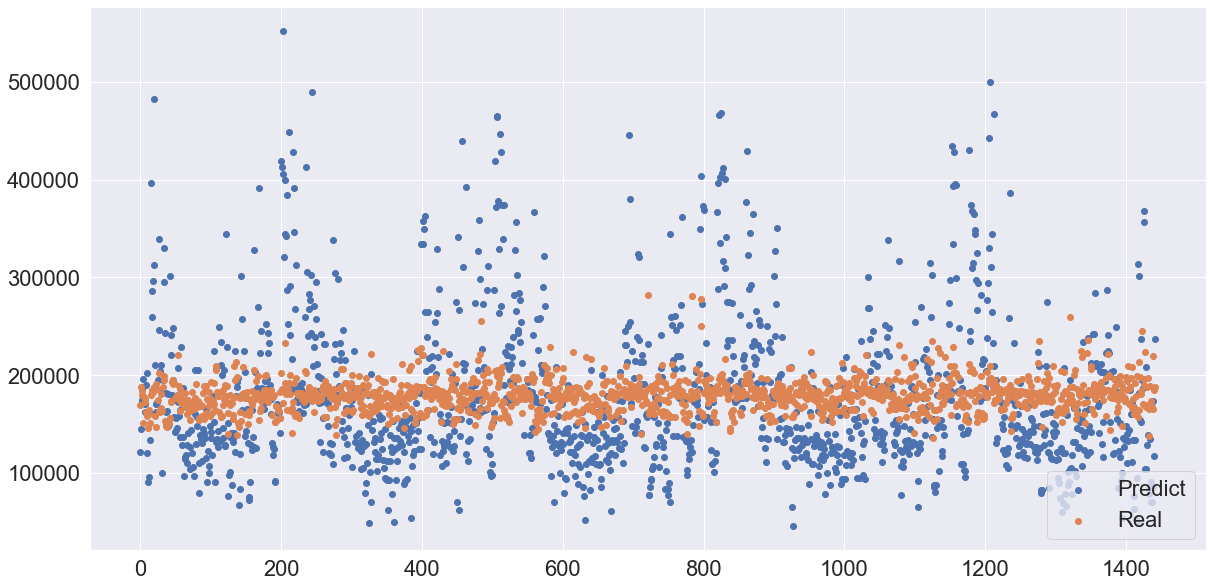

Mean squared error:  5442625643.82022
Mean absolute error:  55797.82963192446
Coefficient of determination:  -18.845261573611722
Mean absolute percentage error:  31.139253894085755 %
Mean squared log error:  0.14872843679794057
Root Mean Squared Log Error:  0.38565325980463405


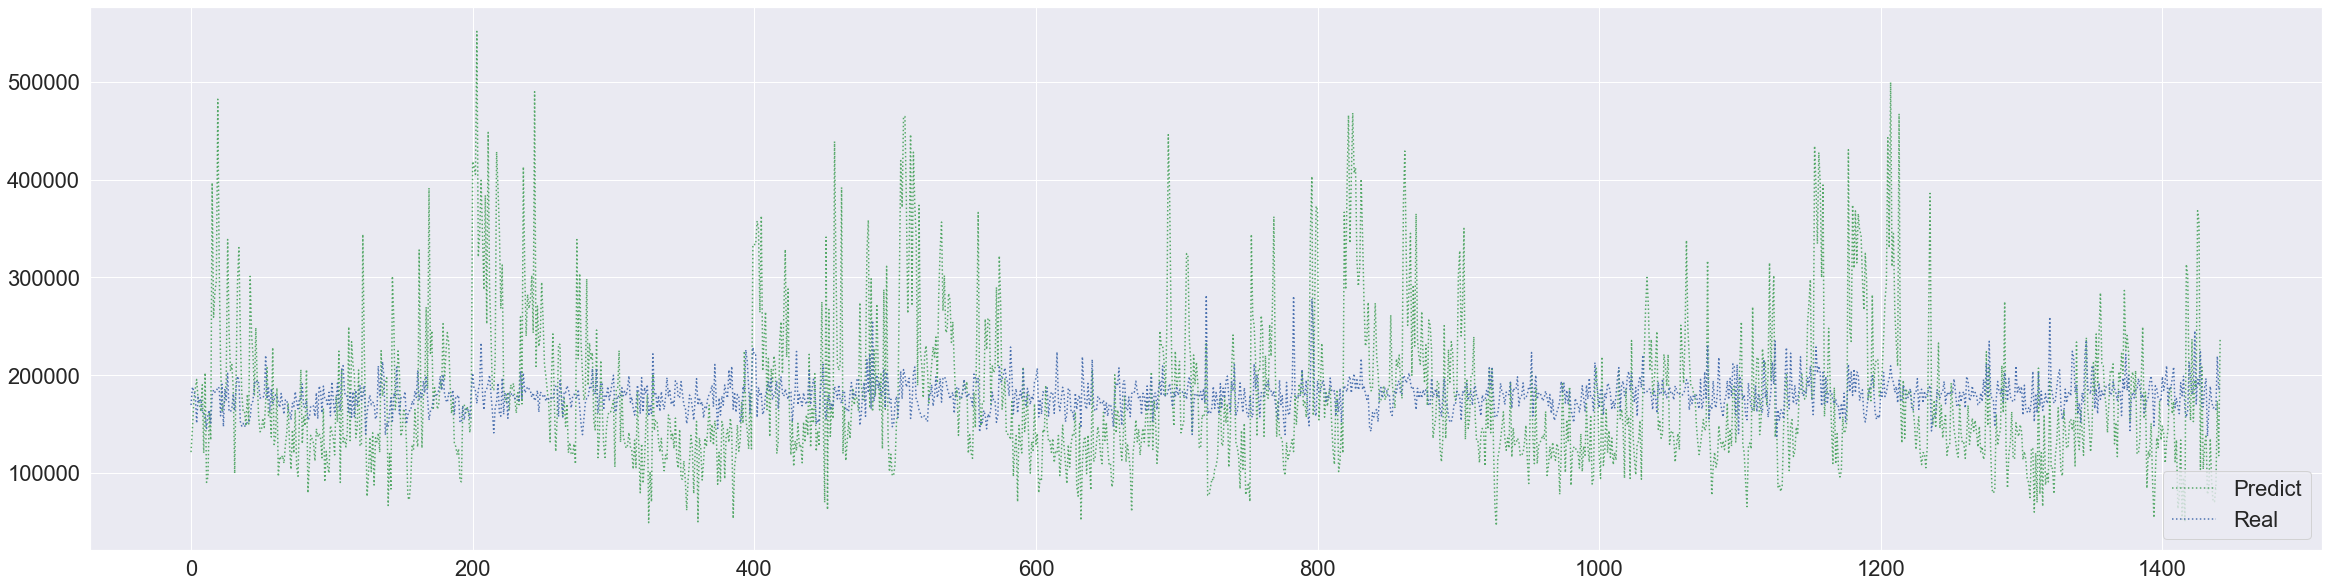

In [299]:
PrintScatterAndCalculateLoos(modelCatBoostRegressor.predict(X_check.numpy()), Y_check)